# Variogram calculation

Script adapted from: https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Variogram.ipynb


## Load the required libraries

In [1]:
#%matplotlib widget
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geopandas as gpd

In [2]:
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python    
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python    

## Declare functions

In [4]:
# utility to convert pandas DataFrame to a GSLIB Geo-EAS file for use with GSLIB methods
def Dataframe2GSLIB(data_file,df):
    colArray = []
    colArray = df.columns
    ncol = len(df.columns) 
    nrow = len(df.index)
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write(str(ncol) + '\n') 
    for icol in range(0, ncol): 
        file_out.write(df.columns[icol]  + '\n')  
    
    for irow in range(0, nrow):
        for icol in range(0, ncol):
            file_out.write(str(df.iloc[irow,icol])+ ' ')  
        file_out.write('\n')

    file_out.close()       

# utility to convert GSLIB Geo-EAS files to a numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny):
    import os
    import numpy as np  

    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)
        
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]
        for iy in range(0,ny):
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ny-1-iy][ix] = head[0].split()[kcol]
    return array,col_name

# utility to convert numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods   
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()
    

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            

# normal score transform, wrapper for nscore from GSLIB (.exe must be in working directory)(not used in this demo)   
def nscore(x):
    import os
    import numpy as np
    file = 'nscore_out.dat'
    ndarray2GSLIB(x,"nscore.dat","value")
    
    file = open("nscore.par", "w")
    file.write("                  Parameters for NSCORE                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("nscore.dat           -file with data                                       \n")
    file.write("1   0                    -  columns for variable and weight                \n")
    file.write("-1.0e21   1.0e21         -  trimming limits                                \n")
    file.write("0                        -1=transform according to specified ref. dist.    \n")
    file.write("../histsmth/histsmth.out -  file with reference dist.                      \n")
    file.write("1   2                    -  columns for variable and weight                \n")
    file.write("nscore.out               -file for output                                  \n")
    file.write("nscore.trn               -file for output transformation table             \n")
    file.close()

    os.system('nscore.exe nscore.par')
    file_in = 'nscore.out'
    y,name = GSLIB2ndarray('nscore.out',1,nx,ny)
    return(y)

# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gamv_2d(df,xcol,ycol,vcol,nlag,lagdist,azi,atol,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':df[vcol]})
    Dataframe2GSLIB("gamv_out.dat",df_ext)
    
    file = open("gamv.par", "w")
    
    file.write("                  Parameters for GAMV                                      \n")
    file.write("                  *******************                                      \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gamv_out.dat                    -file with data                            \n") 
    file.write("1   2   0                         -   columns for X, Y, Z coordinates      \n")
    file.write("1   3   0                         -   number of variables,col numbers      \n")
    file.write("-1.0e21     1.0e21                -   trimming limits                      \n")
    file.write("gamv.out                          -file for variogram output               \n")
    file.write(str(nlag) + "                      -number of lags                          \n")
    file.write(str(lagdist) + "                       -lag separation distance                 \n")
    file.write(str(lagdist*0.5) + "                   -lag tolerance                           \n")
    file.write("1                                 -number of directions                    \n")
    file.write(str(azi) + " " + str(atol) + " 99999.9 0.0  90.0  50.0  -azm,atol,bandh,dip,dtol,bandv \n")
    file.write(str(bstand) + "                    -standardize sills? (0=no, 1=yes)        \n")
    file.write("1                                 -number of variograms                    \n")
    file.write("1   1   1                         -tail var., head var., variogram type    \n")
    file.close()
    
    os.system('gamv.exe gamv.par')
    reading = True
    with open("gamv.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# irregular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmapv_2d(df,xcol,ycol,vcol,nx,ny,lagdist,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':df[vcol]})
    Dataframe2GSLIB("varmap_out.dat",df_ext)
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   3                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("0                            -1=regular grid, 0=scattered values           \n")
    file.write(" 50   50    1                -if =1: nx,     ny,   nz                      \n")
    file.write("1.0  1.0  1.0                -       xsiz, ysiz, zsiz                      \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nx) + " " + str(ny) + " 0 " + "-nxlag, nylag, nzlag                     \n")
    file.write(str(lagdist) + " " + str(lagdist) + " 1.0              -dxlag, dylag, dzlag \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nx*2+1; nny = ny*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nx)+0.5)*lagdist); xmin = -1*xmax; 
    ymax = ((float(ny)+0.5)*lagdist); ymin = -1*ymax; 
    #I'm blocking out the plotting function because I want to do this myself
    #pixelplt(varmap,xmin,xmax,ymin,ymax,lagdist,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# variogram model, 2D wrapper for vmodel from GSLIB (.exe must be in working directory)
def vmodel_2d(nlag,step,azi,nug,nst,tstr1,c1,azi1,rmaj1,rmin1,tstr2=1,c2=0,azi2=0,rmaj2=0,rmin2=0):
    import os
    import numpy as np

    lag = []; gamma = []
    
    file = open("vmodel.par", "w")
    file.write("                                                                           \n")
    file.write("                  Parameters for VMODEL                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("vmodel.var                   -file for variogram output                    \n")
    file.write("1 " + str(nlag) + "          -number of directions and lags                \n")
    file.write(str(azi) + " 0.0 " + str(step) + " -azm, dip, lag distance                  \n")
    file.write(str(nst) + " " + str(nug) + " -nst, nugget effect                           \n")
    file.write(str(tstr1) + " " + str(c1) + " " + str(azi1) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj1) + " " + str(rmin1) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.write(str(tstr2) + " " + str(c2) + " " + str(azi2) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj2) + " " + str(rmin2) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.close()
    
    os.system('vmodel.exe vmodel.par')
    reading = True
    with open("vmodel.var") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma)               


## Set the working directoryb

In [5]:
os.chdir(r"C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\variogram")   

## Load the Willunga water level data

In [6]:
outputdatapath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'

df = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_a1.csv"))
df.head()

,DHNO,DHNO.1,Unit_No,Unit_Number,dh_name,network,Obs_No,drillhole_class,water_point_type_code,Aquifer,...,map_2_5k,map_1k,water_info,salinity,water_chemistry,geophys_log,drill_log,lith_log,geometry,Datetime
0,26558,26558,6527-562,652700562,WLG 40,MCL_VALE,WLG040,WW,NaN,Te2,...,l,2,Y,Y,Y,Y,Y,Y,POINT (268941.81 6093083.52),2021-08-09
1,26565,26565,6527-569,652700569,NaN,MCL_VALE,WLG044,WW,NaN,Te2,...,d,1,Y,Y,Y,Y,Y,Y,POINT (270906.82 6096136.56),2021-10-09
2,26585,26585,6527-589,652700589,NaN,MCL_VALE,WLG019,WW,NaN,Qpa,...,n,3,Y,Y,N,Y,N,N,POINT (272506.29 6097255.78),2021-10-09
3,27050,27050,6527-1054,652701054,MAR SITE 12,MCL_VALE,WLG049,WW,NaN,Tomw,...,n,3,Y,Y,Y,N,Y,N,POINT (271897.13 6092138.11),2021-11-19
4,27063,27063,6527-1067,652701067,NaN,MCL_VALE,WLG057,WW,NaN,Qpa,...,d,6,Y,Y,Y,Y,Y,Y,POINT (270438.32 6089954.64),2021-10-09


Text(0, 0.5, 'Latitude')

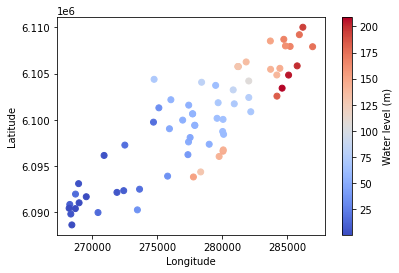

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

s = ax.scatter(df.mga_easting, df.mga_northing, c=df.rswl, cmap="coolwarm")
cb = plt.colorbar(s)
cb.set_label('Water level (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

## Change format of df with water level data 

To make it more useable for this script

In [8]:
df_utm = df.drop(columns=['DHNO', 'DHNO.1', 'Unit_No', 'Unit_Number', 'dh_name', 'network',
       'Obs_No', 'drillhole_class', 'water_point_type_code', 'Aquifer',
       'Orig_drilled_depth', 'Orig_drilled_date', 'max_drill_depth',
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam', 'purpose', 'latest_status',
       'latest_status_date', 'dtw', 'swl', 'water_level_date', 'TDS',
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
       'mga_zone', 'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'decimal_lat', 'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime'])

In [9]:
df = df_utm.rename(columns={'rswl':'Z', 'mga_easting':'X', 'mga_northing':'Y'})
df.head()
len(df)

67

## Create a variogram map for the Willunga data 


Need a lot of data to calculate a variogram map

First, define the parameters to use

In [10]:
nlagx = 70#7
nlagy = 70 #7
lagdist = 1000#3
minpairs = 5#5
vmax = 1.2#1.2
bstand = 1#0
nx = len(df) #100
ny = nx

print("nlagx: %s" %nlagx)
print("nlagy: %s" %nlagy)
print("lag distance: %s" %lagdist)
print("min pairs: %s" %minpairs)
print("vmax: %s" %vmax)
print(bstand)
print("nx: %s" %nx)
print("ny: %s" %ny)



nlagx: 70
nlagy: 70
lag distance: 1000
min pairs: 5
vmax: 1.2
1
nx: 67
ny: 67


In [11]:
hsiz=1
xmax = ((float(nlagx)+0.5)*hsiz)
print(xmax)
xmin = -1*xmax
print(xmin)
ymax = ((float(nlagy)+0.5)*hsiz)
print(ymax)
ymin = -1*ymax
print(ymin)
step =1
xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))

plt.figure(figsize=(8,6))

70.5
-70.5
70.5
-70.5


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [12]:
cmap='viridis'
varmap_irregular = varmapv_2d(df,'X','Y','Z', nlagx, nlagy, lagdist,
                              minpairs,
                              vmax,
                              bstand,'Variogram Map for N[Head] Random Sample','Variogram')

print(type(varmap_irregular))
print(np.shape(varmap_irregular))

<class 'numpy.ndarray'>
(141, 141)


(-15.0, 15.0)

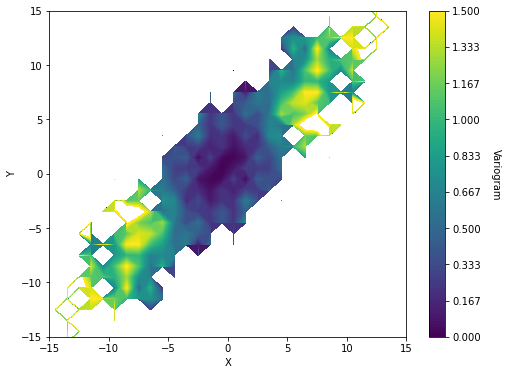

In [13]:
vmin = 0
vmax = 1.5
xlabel = "X"
ylabel = "Y"

plt.figure(figsize=(8,6))
im = plt.contourf(xx, yy, varmap_irregular, cmap=cmap, 
                  vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label("Variogram", rotation=270, labelpad=20)
plt.xlim([-15,15])
plt.ylim([-15,15])

# Calculate the isotropic variogram

## Set the variogram calculation parameters

vargplt(lag, gamma, npair, vtype, name, xmin, xmax, ymin, ymax, sill, title, cmap)

- In practice, the experimental variogram is usually computed using vectors on a length inferior to half the diameter of a region.

In [14]:
nlag = 1000
lag = 100
azi = 90
atol = 90
standardize = 1#0 

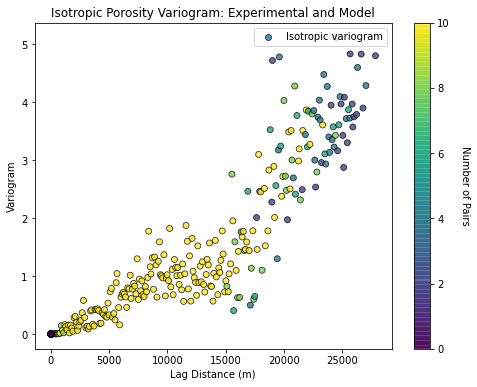

In [15]:
lag_iso, gamma_iso, npair_iso = gamv_2d(df, 'X', 'Y', 'Z', nlag, lag, azi, atol, standardize)  

#print(lag_iso)
#print(gamma_iso)
#print(npair_iso)

plt.figure(figsize=(8,6))
name_iso = 'Isotropic variogram'
title = "Isotropic Porosity Variogram: Experimental and Model"

im = plt.scatter(lag_iso, gamma_iso, c=npair_iso, label = name_iso, 
                 cmap=cmap, vmax=10,alpha=0.8, linewidths=0.8, edgecolors="black")

plt.title(title)
plt.xlabel('Lag Distance (m)')
plt.ylabel('Variogram')
#plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
plt.legend(loc = 1)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Number of Pairs', rotation=270, labelpad=20)

# Plot the directional variogram

Principal direction = 45 degrees
Secondary direction = 135 degrees

In [16]:
standardize = 1#0  

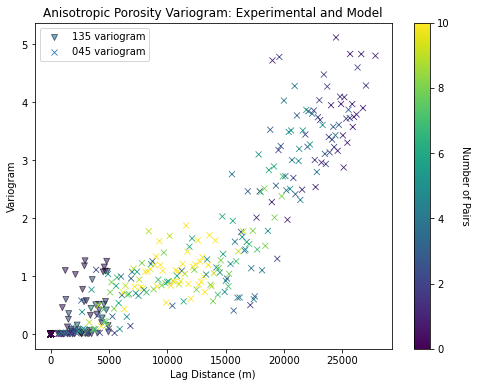

In [17]:
azi = 45
atol = 22.5
nlag = 500
lag = 100
lag_045, gamma_045, npair_045 = gamv_2d(df, 'X', 'Y', 'Z', nlag, lag, azi, atol, standardize) 
azi = 135
atol = 22.5
nlag = 100
lag = 50
lag_135, gamma_135, npair_135 = gamv_2d(df, 'X', 'Y', 'Z', nlag, lag, azi, atol, standardize)  


plt.figure(figsize=(8,6))

title = "Anisotropic Porosity Variogram: Experimental and Model"
name = '135 variogram'
im = plt.scatter(lag_135, gamma_135, c = npair_135, label = name, marker = 'v', 
                 cmap = cmap, vmax=10, alpha=0.6, linewidths=0.8, edgecolors="black")

name = '045 variogram'
im = plt.scatter(lag_045, gamma_045, c = npair_045, label = name, marker = 'x', 
                 cmap = cmap, vmax=10, linewidths=0.8, edgecolors="black")


plt.title(title)
plt.xlabel('Lag Distance (m)')
plt.ylabel('Variogram')
#plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
plt.legend(loc = 0)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Number of Pairs', rotation=270, labelpad=20)


## The variogram cloud

Compare to variogram calculation using all data points exactly

In [18]:
xy = df
label = "Z"
dxy = np.zeros( [ len(xy), len(xy) ], dtype=float )
dkv = np.zeros( [ len(xy), len(xy) ], dtype=float )
print(xy.head())

       Z          X           Y  decimal_long  neg_decimal_lat
0   4.09  268941.81  6093083.52    138.459534       -35.278757
1   4.33  270906.82  6096136.56    138.481972       -35.251705
2  18.22  272506.29  6097255.78    138.499847       -35.241988
3   5.54  271897.13  6092138.11    138.491737       -35.287951
4  15.90  270438.32  6089954.64    138.475098       -35.307286


In [19]:
for i in range(len(xy)):
        for j in range(len(xy)):
            dxy[i,j] = np.sqrt( ((xy['X'][i]-xy['X'][j])**2.) +
                                ((xy['Y'][i]-xy['Y'][j])**2.) )
            dkv[i,j] = ( (xy[label][i]-xy[label][j])**2. )/2.

In [20]:
tup = [ [i,j] for i,j in zip( np.tril(dxy)[ (np.tril(dxy)!= 0.) & (np.tril(dkv)!= 0.) & (~np.isnan(np.tril(dxy))) ]/1000.,
                                  np.tril(dkv)[ (np.tril(dxy)!= 0.) & (np.tril(dkv)!= 0.) & (~np.isnan(np.tril(dxy))) ] ) ]
tup.sort()

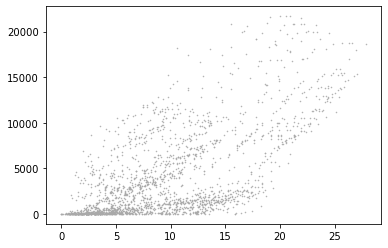

In [21]:
tup = np.array(tup)

f = plt.figure()
s = f.add_subplot(111)
s.xaxis.set_ticks_position('bottom')
s.yaxis.set_ticks_position('left')
s.plot( tup[:,0], tup[:,1], 'o', ms=0.5, mec='DarkGray', mfc='DarkGray' )

In [69]:
ssz = 100    
L,x,y = [0.],[],[]
for i in range(int(len(tup)/ssz)):
    t = tup[ i*100:(i+1)*100, : ]
    x.append( np.sum(t[:,0])/len(t[:,0]) )
    y.append( np.sum(t[:,1])/len(t[:,1]) )
    
    L.append( t[-1,0])

Text(0, 0.5, 'Autocorrelation')

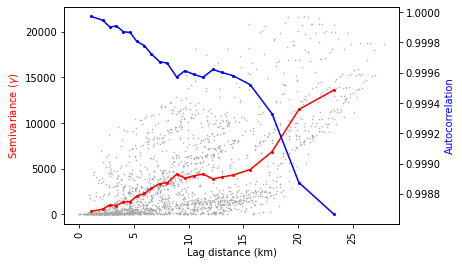

In [70]:
L.append(250.)

f = plt.figure()
s = f.add_subplot(111)
s.xaxis.set_ticks_position('bottom')
s.yaxis.set_ticks_position('left')
s.plot( tup[:,0], tup[:,1], 'o', ms=0.5, mec='DarkGray', mfc='DarkGray' )

x,y = np.array(x),np.array(y)
x2 = np.concatenate( [ 0.001*np.ones([1]), x ] )
s.plot( x, y, 'o-', c='r', ms=2, mec='r', mfc='r' )
s2 = s.twinx()
s2.plot( x, 1.-(y/np.var(y)), 'o-', c='b', ms=2, mec='b', mfc='b' )

plt.setp( s.xaxis.get_majorticklabels(), rotation=90 )
s.set_xlabel('Lag distance (km)')
s.set_ylabel('Semivariance (${\gamma}$)', c="r")
s2.set_ylabel('Autocorrelation', c="b")

# Universal kriging

We can see that the data is non-stationary so we need to remove the trend prior to kriging

## Trend estimation

Let's look at the data again## Trend estimation


In [23]:
print(df["X"].describe())
print(df["Y"].describe())

count        67.000000
mean     278058.598507
std        5392.086518
min      268211.780000
25%      274737.260000
50%      278422.620000
75%      281955.715000
max      286977.760000
Name: X, dtype: float64
count    6.700000e+01
mean     6.099594e+06
std      5.841892e+03
min      6.088617e+06
25%      6.095189e+06
50%      6.100037e+06
75%      6.104284e+06
max      6.110009e+06
Name: Y, dtype: float64


Text(276977, 6098009.0, '??Trend direction??')

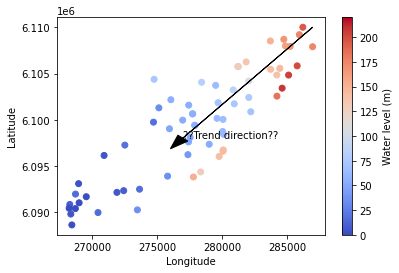

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

s = ax.scatter(df.X, df.Y, c=df.Z, cmap="coolwarm", vmin=0, vmax=220)
cb = plt.colorbar(s)
cb.set_label('Water level (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

dx=-10000;dy=-12000
plt.arrow(286977, 6.110009e+06, dx, dy, head_width=1000, color='k')
plt.text(286977+dx, 6.110009e+06+dy, '??Trend direction??')

In [25]:
from sklearn import linear_model

X = df[['X', 'Y']]
y = df['Z']

regr = linear_model.LinearRegression()
regr.fit(X, y)

print(regr.coef_)

xcoeff = regr.coef_[0]
ycoeff = regr.coef_[1]

[ 0.01140619 -0.00110073]


## Predict the values across a grid to look at the trend 

Does it look ok?

Predict across my grid.

,FID,geometry
0,0,POINT (138.72246 -35.14685)
1,1,POINT (138.71624 -35.14685)
2,2,POINT (138.71624 -35.14211)
3,3,POINT (138.72869 -35.14211)
4,4,POINT (138.70380 -35.14211)
...,...,...
1069,1069,POINT (138.44867 -35.31735)
1070,1070,POINT (138.47356 -35.31735)
1071,1071,POINT (138.46734 -35.31261)
1072,1072,POINT (138.48601 -35.31261)


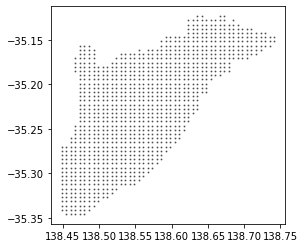

In [26]:
shppath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'
shppath = (os.path.join(shppath,'willunga_regular_grid.shp'))  

study_grid = gpd.read_file(shppath)


plt.figure()
ax=plt.subplot(111)
study_grid.plot(ax=ax, color="k", alpha=0.5, markersize=1)

study_grid.head()

study_grid

### Change shapefile crs & extract x and y locs

epsg:32754 -- UTM zone 54S 

In [27]:
study_grid = study_grid.to_crs('epsg:32754')

study_grid.head()

,FID,geometry
0,0,POINT (292524.388 6108297.551)
1,1,POINT (291957.436 6108284.552)
2,2,POINT (291945.375 6108809.925)
3,3,POINT (293079.343 6108835.885)
4,4,POINT (290811.404 6108783.823)


In [28]:
study_grid_xy = []
for ix in study_grid.index:
    a = study_grid.loc[ix, 'geometry']
    study_grid_xy.append([a.x, a.y])
print(study_grid_xy[0])
print(len(study_grid_xy))

[292524.3877725701, 6108297.550605189]
1074


### Predict z values for each value on the grid

Based on the trend only


In [29]:
predicted_z = regr.predict(study_grid_xy)

print(predicted_z)
print(len(predicted_z))

[237.05417114 230.60172384 229.88586393 ...  -1.87850005  17.43581305
  -8.31654668]
1074


In [30]:
study_grid["predicted_z"] = predicted_z
study_grid.head()

,FID,geometry,predicted_z
0,0,POINT (292524.388 6108297.551),237.054171
1,1,POINT (291957.436 6108284.552),230.601724
2,2,POINT (291945.375 6108809.925),229.885864
3,3,POINT (293079.343 6108835.885),242.791541
4,4,POINT (290811.404 6108783.823),216.980306


### Plot the estimated trend

<AxesSubplot:>

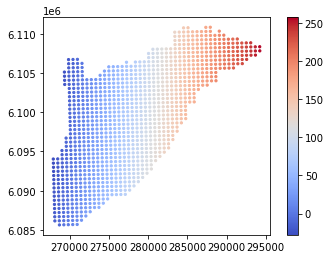

In [31]:
plt.figure()
ax=plt.subplot(111)
study_grid.plot(ax=ax, column="predicted_z", markersize=5, cmap="coolwarm",legend=True)

### Predict the value at sample locations

So I can calculate the residuals

In [32]:
xy_samples = []

for ix in df.index:
    xy_samples.append([df.loc[ix, "X"],
                       df.loc[ix, "Y"]])
    
print(len(xy_samples))

predicted_z_smpl = regr.predict(xy_samples)

#print(predicted_z_smpl)
print(len(predicted_z_smpl))

df['predicted_z'] = predicted_z_smpl

67
67


In [33]:
print(xcoeff, ycoeff)

0.01140618699344591 -0.0011007263735702895


Text(0, 0.5, 'Latitude')

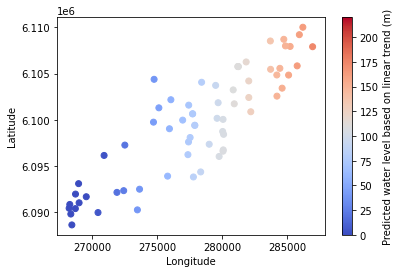

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

s = ax.scatter(df.X, df.Y, c=df.predicted_z, cmap="coolwarm", vmin=0, vmax=220)
cb = plt.colorbar(s)
cb.set_label('Predicted water level based on linear trend (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

### Remove the trend from the data

To prepare for universal kriging

x and y coefficients are xcoeff = 0.01155715 ycoeff = -0.0012431 

Text(0, 0.5, 'Latitude')

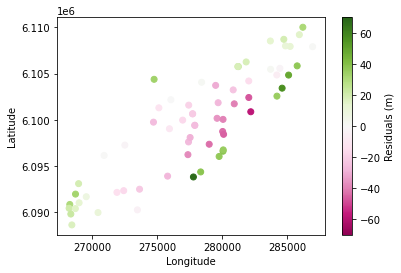

In [37]:
df["residuals"] = df["Z"] - df["predicted_z"]

fig = plt.figure()
ax = fig.add_subplot(111)

s = ax.scatter(df.X, df.Y, c=df.residuals, cmap="PiYG", vmin=-70, vmax=70)
cb = plt.colorbar(s)
cb.set_label('Residuals (m)')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [38]:
df['residuals'].describe()

count    6.700000e+01
mean     9.548846e-13
std      2.853342e+01
min     -5.754045e+01
25%     -2.385171e+01
50%      4.639261e-01
75%      1.993429e+01
max      6.753817e+01
Name: residuals, dtype: float64

# Create a variogram map for the Willunga data residuals

### Do I need to do a transform to remove the negative values?

First, define the parameters to use

In [39]:
nlagx = 70#7
nlagy = 70 #7
lagdist = 1000#3
minpairs = 5#5
vmax = 1.2#1.2
bstand = 1#0
nx = len(df) #100
ny = nx

In [40]:
hsiz=1
xmax = ((float(nlagx)+0.5)*hsiz)
xmin = -1*xmax
ymax = ((float(nlagy)+0.5)*hsiz)
ymin = -1*ymax
step =1
xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))

In [41]:
cmap='viridis'
varmap_irregular = varmapv_2d(df,'X','Y','residuals', nlagx, nlagy, lagdist,
                              minpairs,
                              vmax,
                              bstand,'Variogram Map for N[Head] Residuals Random Sample','Variogram')

print(type(varmap_irregular))
print(np.shape(varmap_irregular))

<class 'numpy.ndarray'>
(141, 141)


(-15.0, 15.0)

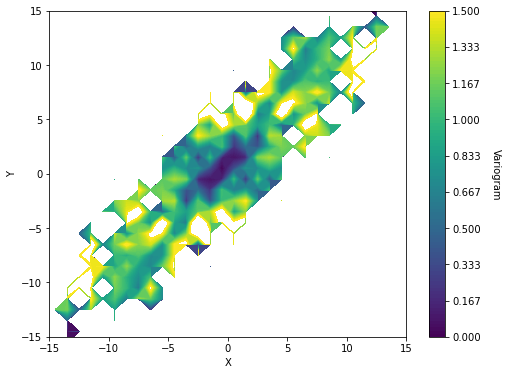

In [42]:
vmin = 0
vmax = 1.5
xlabel = "X"
ylabel = "Y"

plt.figure(figsize=(8,6))
im = plt.contourf(xx, yy, varmap_irregular, cmap=cmap, 
                  vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label("Variogram", rotation=270, labelpad=20)
plt.xlim([-15,15])
plt.ylim([-15,15])

# Calculate isotropic variogram

For residuals

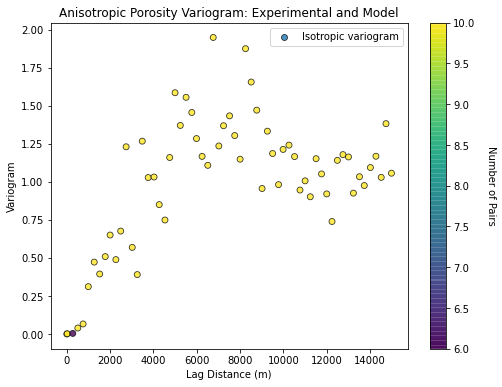

In [43]:
nlag = 60 #60 - so that you cut off extremeties (#full extent 100)
lag = 250 #250 - so that you cut off extremeties (#full extent 250)
azi = 90
atol = 90
standardize = 1#0 

lag_iso, gamma_iso, npair_iso = gamv_2d(df, 'X', 'Y', 'residuals', nlag, lag, azi, atol, standardize)  

#print(lag_iso)
#print(gamma_iso)
#print(npair_iso)

plt.figure(figsize=(8,6))
name_iso = 'Isotropic variogram'
title = "Anisotropic Porosity Variogram: Experimental and Model"

im = plt.scatter(lag_iso, gamma_iso, c=npair_iso, label = name_iso, 
                 cmap=cmap, vmax=10,alpha=0.8, linewidths=0.8, edgecolors="black")

plt.title(title)
plt.xlabel('Lag Distance (m)')
plt.ylabel('Variogram')
#plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
plt.legend(loc = 1)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Number of Pairs', rotation=270, labelpad=20)

# Calculate variogram for linear Z values

Just for fun

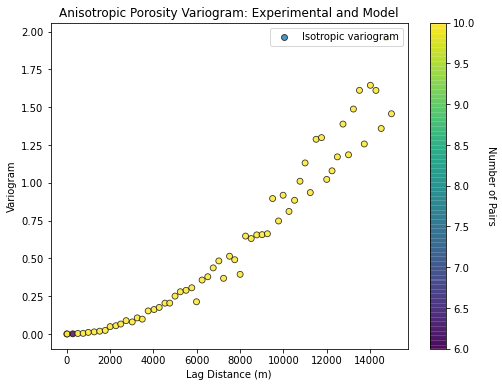

In [44]:
lag_iso, gamma_iso, npair_iso = gamv_2d(df, 'X', 'Y', 'predicted_z', nlag, lag, azi, atol, standardize)  

#print(lag_iso)
#print(gamma_iso)
#print(npair_iso)

plt.figure(figsize=(8,6))
name_iso = 'Isotropic variogram'
title = "Anisotropic Porosity Variogram: Experimental and Model"

im = plt.scatter(lag_iso, gamma_iso, c=npair_iso, label = name_iso, 
                 cmap=cmap, vmax=10,alpha=0.8, linewidths=0.8, edgecolors="black")

plt.title(title)
plt.xlabel('Lag Distance (m)')
plt.ylabel('Variogram')
#plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
plt.legend(loc = 1)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Number of Pairs', rotation=270, labelpad=20)

# Model the variogram function

In [45]:
help(geostats.nscore)     

Help on function nscore in module geostatspy.geostats:

nscore(df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)
    GSLIB's NSCORE program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    :param df: pandas DataFrame with the spatial data
    :param vcol: name of the variable column
    :param wcol: name of the weight column, if None assumes equal weighting
    :param ismooth: if True then use a reference distribution
    :param dfsmooth: pandas DataFrame required if reference distribution is used
    :param smcol: reference distribution property (required if reference
                  distribution is used)
    :param smwcol: reference distribution weight (required if reference
                   distribution is used)
    :return: TODO



### Transform data to Gaussian

In [46]:
#Transform to Gaussian by Facies
df['Nresiduals'], tvPor, tnsPor = geostats.nscore(df, 'residuals') # nscore transform for all facies porosity 
df.head() 

,Z,X,Y,decimal_long,neg_decimal_lat,predicted_z,residuals,Nresiduals
0,4.09,268941.81,6093083.52,138.459534,-35.278757,-15.186636,19.276636,5.944087e-01
1,4.33,270906.82,6096136.56,138.481972,-35.251705,3.866074,0.463926,-1.490050e-08
2,18.22,272506.29,6097255.78,138.499847,-35.241988,20.877973,-2.657973,-7.489467e-02
3,5.54,271897.13,6092138.11,138.491737,-35.287951,19.562934,-14.022934,-3.039132e-01
4,15.90,270438.32,6089954.64,138.475098,-35.307286,5.326878,10.573122,1.881663e-01


### Plot data transformation

Plot original and transformed residuals histograms

In [47]:
np.linspace

<function numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)>

In [67]:
'''
plt.figure(figsize=(10,10))

# Original
plt.subplot(221)                                        
plt.hist(df['residuals'], facecolor='red', bins=np.linspace(-50,50,1000),
         histtype="stepfilled", alpha=0.2, density=True, cumulative=True,
         edgecolor='black', label='Original')
plt.xlabel('Residuals of head with trend removed (m)')
plt.ylabel('Frequency')
#plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

# Normal transform
plt.subplot(222)  
plt.hist(df['Nresiduals'], facecolor='blue', bins=np.linspace(-3.0,3.0,1000),
         histtype="stepfilled", alpha=0.2, density=True, cumulative=True,
         edgecolor='black', label = 'Transformed')

plt.xlabel('Residuals of head with trend removed (m)')
plt.ylabel('Frequency')
#plt.title('Nscore Porosity')
plt.legend(loc='upper left')
plt.grid(True)
'''

'\nplt.figure(figsize=(10,10))\n\n# Original\nplt.subplot(221)                                        \nplt.hist(df[\'residuals\'], facecolor=\'red\', bins=np.linspace(-50,50,1000),\n         histtype="stepfilled", alpha=0.2, density=True, cumulative=True,\n         edgecolor=\'black\', label=\'Original\')\nplt.xlabel(\'Residuals of head with trend removed (m)\')\nplt.ylabel(\'Frequency\')\n#plt.title(\'Porosity\')\nplt.legend(loc=\'upper left\')\nplt.grid(True)\n\n# Normal transform\nplt.subplot(222)  \nplt.hist(df[\'Nresiduals\'], facecolor=\'blue\', bins=np.linspace(-3.0,3.0,1000),\n         histtype="stepfilled", alpha=0.2, density=True, cumulative=True,\n         edgecolor=\'black\', label = \'Transformed\')\n\nplt.xlabel(\'Residuals of head with trend removed (m)\')\nplt.ylabel(\'Frequency\')\n#plt.title(\'Nscore Porosity\')\nplt.legend(loc=\'upper left\')\nplt.grid(True)\n'

### Remake my variograms

The 45 degrees structure works better with more lags, to extend to ~10-12 km but the second structure at 135 degrees is better with only about 4 km

From GSLIB textbook:

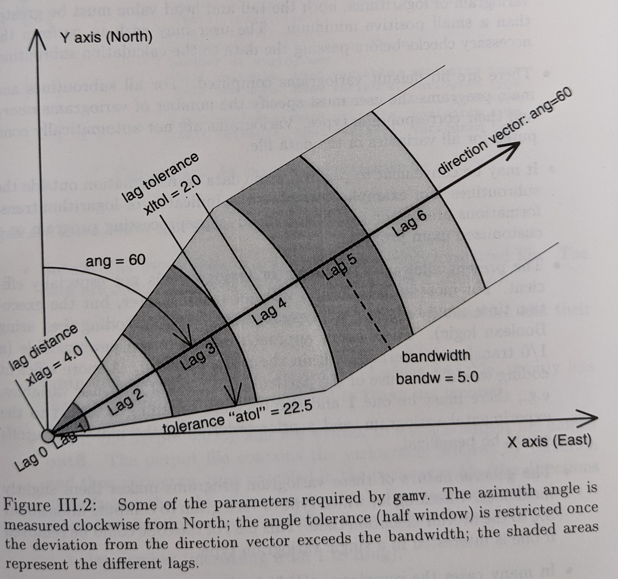

In [104]:
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 1000.0; lag_tol = 1000.0; nlag = 12;         # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms (22.5)
isill = 1                                               # standardize sill, if set to 1 the semivarvals will be divided by var
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to considerb

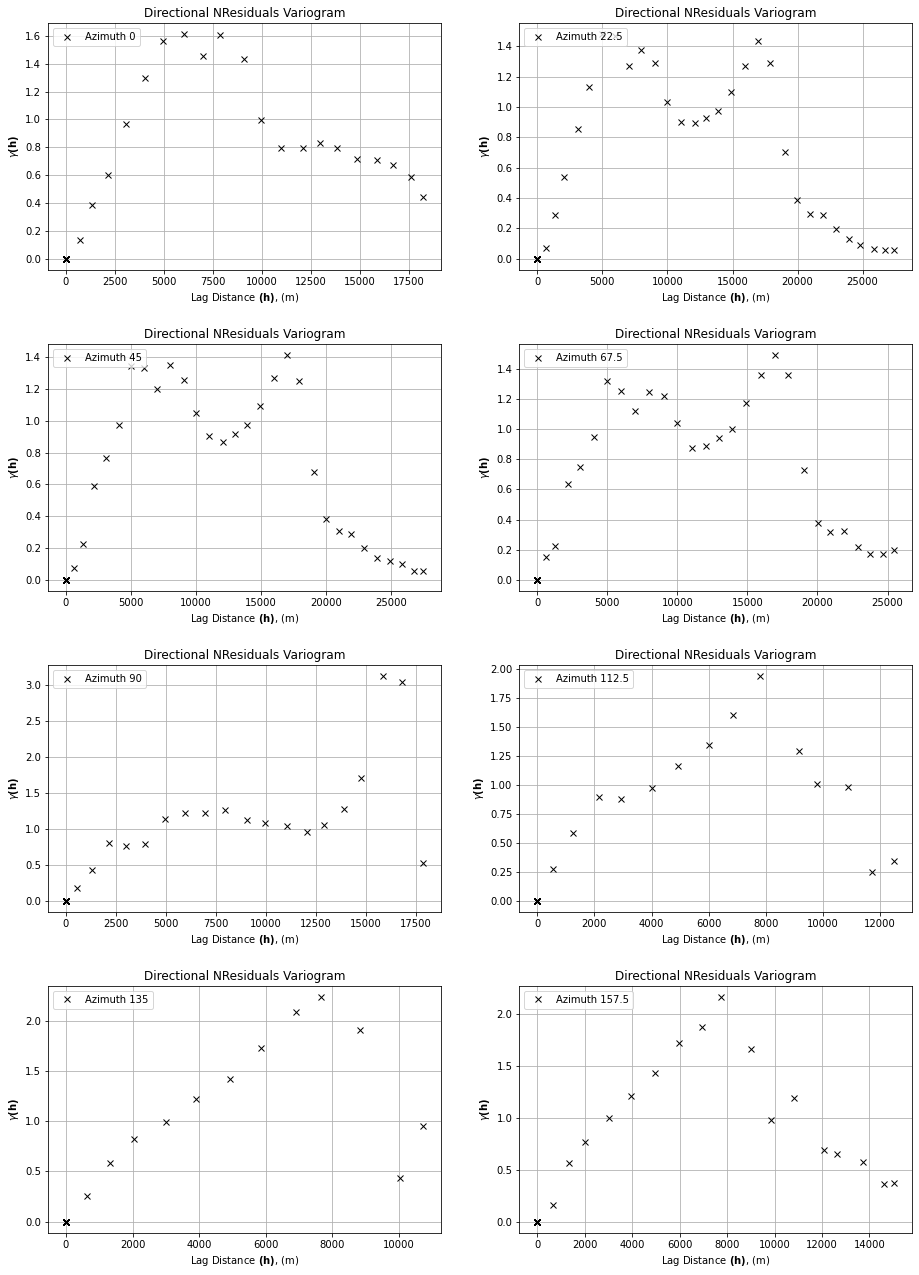

In [157]:
#To make isotropic atol=90. For very anisotropic = 22.5
atol=45#90

# Arrays to store the results - these are really long don't need to be this long??
lag =   np.zeros((len(azi_mat),nlag+2))
gamma = np.zeros((len(azi_mat),nlag+2))
npp = np.zeros((len(azi_mat),nlag+2))

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df,"X","Y","Nresiduals", #Nresiduals
                                                            tmin, tmax, lag_dist,
                                                            lag_tol, nlag, azi_mat[iazi], atol, bandh, isill)

    plt.subplot(4,2,iazi+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    #plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NResiduals Variogram')
    #plt.xlim([0,700])
    #plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

### Model these variogram

Start with the principal directions of 45 and 135

It's very hard to get info on the GSLIB.make_variogram function - it is not in the textbook and not well described in geostatsguy code. He says "Make a dictionary of variogram parameters for application with spatial
    estimation and simulation."
    
The code doesn't say what the parameters are so I don't know how to change the model type for example

In [127]:
GSLIB.make_variogram

<function geostatspy.GSLIB.make_variogram(nug, nst, it1, cc1, azi1, hmaj1, hmin1, it2=1, cc2=0, azi2=0, hmaj2=0, hmin2=0)>

## Plot the theoretical variograms

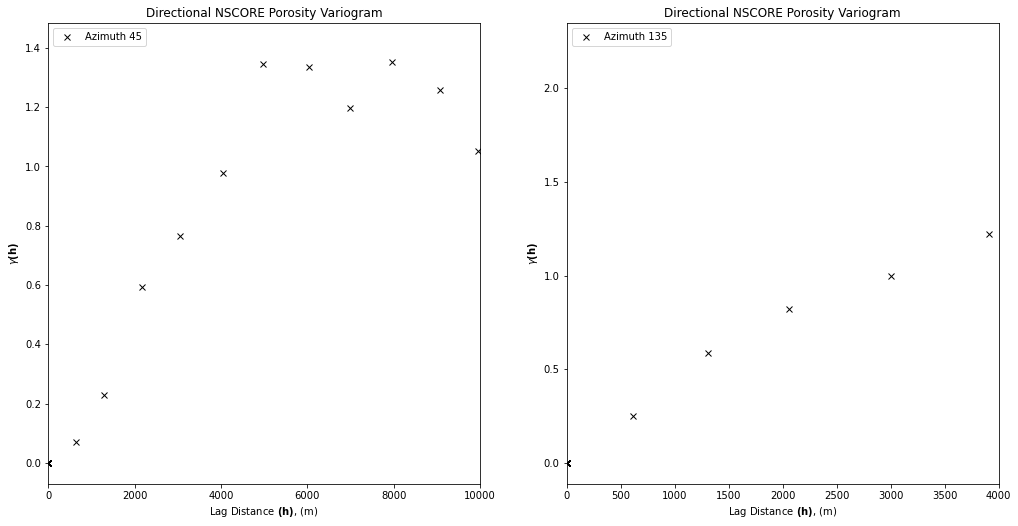

In [158]:
plt.subplot(1,2,1)
plt.plot(lag[2,:], gamma[2,:] ,'x', color = 'black', label = 'Azimuth ' + str(azi_mat[2]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,10000])
#plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(lag[6,:], gamma[6,:], 'x',color = 'black',label = 'Azimuth ' +str(azi_mat[6]))
#plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,4000])
#plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

## Variogram modelling parameters

In [351]:
nug = 0.0
nst = 1  # Number of nest structure variogram model parameters, for now I think one is enough

# My guess at the types
# 0 = nugget
# 1 = Sph
# 2 = Exp 
# 3 = Gaussian

# First structure
it1 = 3 #3   # Type 
cc1 = 1.0 #900 #1.0 #.9 Contribution of this structure
azi1 = 45 #45       # Major azimuth 
hmaj1 = 4200 #5000  # Range for major geometric direction
hmin1 = 2500 #2000  # Range for the minor geometric direction

'''
# Second structure
it2 = 1 
cc2 = .1
azi2 = 45
hmaj2 = 9999.9
hmin2 = 6000 # 2000 looks good but maybe too small...? 

vario = GSLIB.make_variogram(nug, nst, it1, cc1, azi1, 
                             hmaj1, hmin1, it2, cc2, azi2, hmaj2, hmin2) # make model object
'''
vario = GSLIB.make_variogram(nug, nst, it1, cc1, azi1, 
                             hmaj1, hmin1) # make model object

# project the model in the 045 azimuth
nlag = 3000
xlag = 10
azm = 45                                
index45, h45, gam45, cov45, ro45 = geostats.vmodel(nlag, xlag, azm, vario)

# project the model in the 135 azimuth
azm = 135                                                      
index135, h135, gam135, cov135, ro135 = geostats.vmodel(nlag, xlag, azm, vario)

 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067830903227,-7.071067792827723


## Fit the variogram automatically

Use this function:

scipy.optimize.curve_fit 

In [352]:
h45


array([0.000e+00, 1.000e+01, 2.000e+01, ..., 2.998e+04, 2.999e+04,
       3.000e+04])

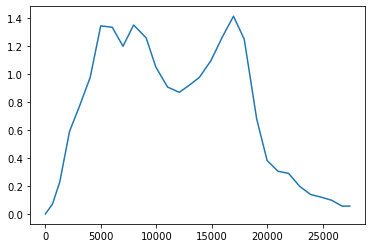

In [353]:
# For some reason these are really long and have 0s at the end

to_fit_45_y = gamma[2,:30] 
to_fit_135_y = gamma[6,:13]
to_fit_45_x = lag[2,:30]
to_fit_135_x = lag[6,:13]

#print(to_fit_45_x)
#print(to_fit_45_y)

plt.plot(to_fit_45_x, to_fit_45_y)

In [354]:

# Round to nearest 10m
rounded_45_x = []
for i in to_fit_45_x:
    rounded_45_x.append(round(i/10)*10)
    
print(rounded_45_x)
rounded_45_x = np.array(rounded_45_x)

a = np.where(rounded_45_x==72)
print(a)
np.shape(a)
print(a[0])

[0, 640, 1290, 2180, 3040, 4040, 4980, 6030, 6990, 7950, 9080, 9950, 11010, 12070, 12950, 13880, 14920, 15970, 16950, 17920, 19040, 19980, 20970, 21910, 22920, 23900, 24890, 25800, 26750, 27440]
(array([], dtype=int64),)
[]


In [363]:
print(h45)
print(h45[-1])
print(round(h45[-1]))
print(to_fit_45_y)

[0.000e+00 1.000e+01 2.000e+01 ... 2.998e+04 2.999e+04 3.000e+04]
29999.999999999738
30000
[0.         0.07112128 0.22765683 0.59181291 0.76422064 0.97708827
 1.3446572  1.33443925 1.19891513 1.35084994 1.25928918 1.05067066
 0.90721149 0.86934172 0.91939861 0.97625154 1.09557331 1.26847511
 1.41338784 1.24882166 0.67951929 0.38174072 0.30454883 0.29005009
 0.19703671 0.13874189 0.11904706 0.09771361 0.05537963 0.05617862]


In [427]:
# Map the y variable to an array with the same size as the x
xvals = []
yvals = []

count = 0
y_idx = 0


for i in h45:
    #print("h45: %1.0f" %i)
    i_round = round(i)
    xvals.append(i_round)
    
    if np.where(rounded_45_x==i_round)[0].size > 0:
        y_idx = np.where(rounded_45_x==i_round)[0]
        yvals.append(to_fit_45_y[y_idx][0])
        #print("x: %i" %i_round)
        #print("y: %2.3f" %to_fit_45_y[np.where(rounded_45_x==i_round)[0]])
        
    else:
        yvals.append(np.nan)

        
print(len(xvals))   
print(len(yvals))

3001
3001


In [432]:
print(yvals)

[0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.07112128216942096, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.22765683378259197, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [483]:
i=0

yvals_interpolated = np.copy(yvals)

y_indexes = []

for i in range(len(to_fit_45_y)-1):
    
    prev_yval = to_fit_45_y[i]
    this_yval = to_fit_45_y[i+1]

    prev_idx = np.where(yvals==prev_yval)[0][0]
    this_idx = np.where(yvals==this_yval)[0][0]
    
    y_indexes.append(prev_idx)

    interval_idx = this_idx - prev_idx 
    interval_y = this_yval - prev_yval
    increment = interval_y/(interval_idx)

    # What are the indexes in the yvals array that I need to interpolate/fill in?
    fill_ins_x = np.arange(prev_idx+1, this_idx)

    # Make an array with the multiplier for the increment for my interpolation
    multiplier_array = np.arange(1, (len(fill_ins_x)+1))

    for ix in range(len(fill_ins_x)):
        yvals_interpolated[fill_ins_x[ix]] =  prev_yval + (multiplier_array[ix]*increment)

In [496]:
print(y_indexes)

[0, 64, 129, 218, 304, 404, 498, 603, 699, 795, 908, 995, 1101, 1207, 1295, 1388, 1492, 1597, 1695, 1792, 1904, 1998, 2097, 2191, 2292, 2390, 2489, 2580, 2675]


In [518]:
print(len(yvals_interpolated))
print(yvals_interpolated[2580:2675])

3001
[0.09771361 0.09726799 0.09682237 0.09637675 0.09593113 0.09548551
 0.09503989 0.09459427 0.09414865 0.09370303 0.0932574  0.09281178
 0.09236616 0.09192054 0.09147492 0.0910293  0.09058368 0.09013806
 0.08969244 0.08924682 0.0888012  0.08835557 0.08790995 0.08746433
 0.08701871 0.08657309 0.08612747 0.08568185 0.08523623 0.08479061
 0.08434499 0.08389937 0.08345375 0.08300812 0.0825625  0.08211688
 0.08167126 0.08122564 0.08078002 0.0803344  0.07988878 0.07944316
 0.07899754 0.07855192 0.07810629 0.07766067 0.07721505 0.07676943
 0.07632381 0.07587819 0.07543257 0.07498695 0.07454133 0.07409571
 0.07365009 0.07320446 0.07275884 0.07231322 0.0718676  0.07142198
 0.07097636 0.07053074 0.07008512 0.0696395  0.06919388 0.06874826
 0.06830263 0.06785701 0.06741139 0.06696577 0.06652015 0.06607453
 0.06562891 0.06518329 0.06473767 0.06429205 0.06384643 0.0634008
 0.06295518 0.06250956 0.06206394 0.06161832 0.0611727  0.06072708
 0.06028146 0.05983584 0.05939022 0.0589446  0.05849897 0.

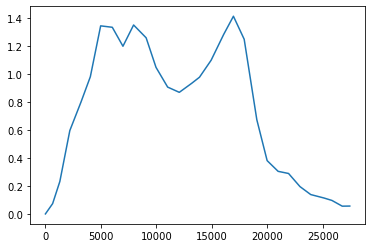

In [489]:
plt.plot(xvals, yvals_interpolated)

In [261]:
print(vario)

{'nug': 0.0, 'nst': 1, 'it1': 3, 'cc1': 1.0, 'azi1': 45, 'hmaj1': 4200, 'hmin1': 2500, 'it2': 1, 'cc2': 0, 'azi2': 0, 'hmaj2': 0, 'hmin2': 0}


## Make function

Now that I have interpolated yvals for the "data"

Note I have already run function to get h45 this is a glitch I need to fix

In [543]:
def modelvariogram_f(xvals, hmaj1, hmin1):
    nug = 0
    nst = 1
    it1 = 3 
    cc1 = 1.0 
    azi1 = 45 
    
    vario = GSLIB.make_variogram(nug, nst, it1, cc1, azi1, 
                                 hmaj1, hmin1)
    
    nlag = 500 # 2500
    xlag = 10
    azm = 45   
    
    index45, h45, gam45, cov45, ro45 = geostats.vmodel(nlag, xlag, azm, vario)
    
    return gam45
    

## Test my function

First crop values to ignore nans

In [544]:
xvals_curvefit = np.copy(xvals)
xvals_curvefit = xvals_curvefit[:501] #2501
yvals_curvefit = np.copy(yvals_interpolated)
yvals_curvefit = yvals_curvefit[:501] # 2501

y_test = modelvariogram_f(xvals_curvefit, 4200, 2500)
len(y_test)
len(xvals_curvefit)

 x,y,z offsets = 7.071067805519558,7.071067818211393


501

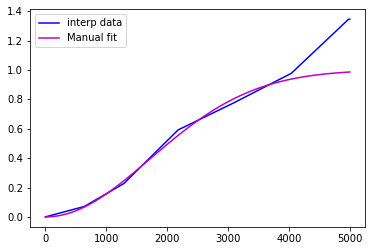

In [545]:
plt.plot(xvals_curvefit, yvals_curvefit, "b", label="interp data")
plt.plot(xvals_curvefit, y_test, "m", label="Manual fit")
plt.legend()

## Optimise

In [548]:
from scipy.optimize import curve_fit


popt, popc = curve_fit(modelvariogram_f, xvals_curvefit, yvals_curvefit,
                      bounds=([3000, 1500], [5000, 3500]))

 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067805519558,7.071067818211393


[4083.74303956 2500.        ]
 x,y,z offsets = 7.071067805519558,7.071067818211393


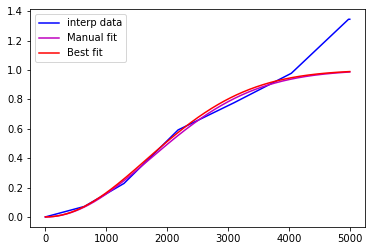

In [549]:
print(popt)
y_best_fit = modelvariogram_f(xvals_curvefit, popt[0], popt[1])
plt.plot(xvals_curvefit, yvals_curvefit, "b", label="interp data")
plt.plot(xvals_curvefit, y_test, "m", label="Manual fit")
plt.plot(xvals_curvefit, y_best_fit, "r", label="Best fit")

#plt.xlim([0, 5000])

plt.legend()

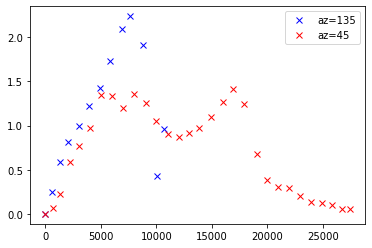

In [257]:
plt.plot(to_fit_135_x, to_fit_135_y, "bx", label="az=135")
plt.plot(to_fit_45_x, to_fit_45_y, "rx", label="az=45")
plt.legend()

### Plot the modelled variograms

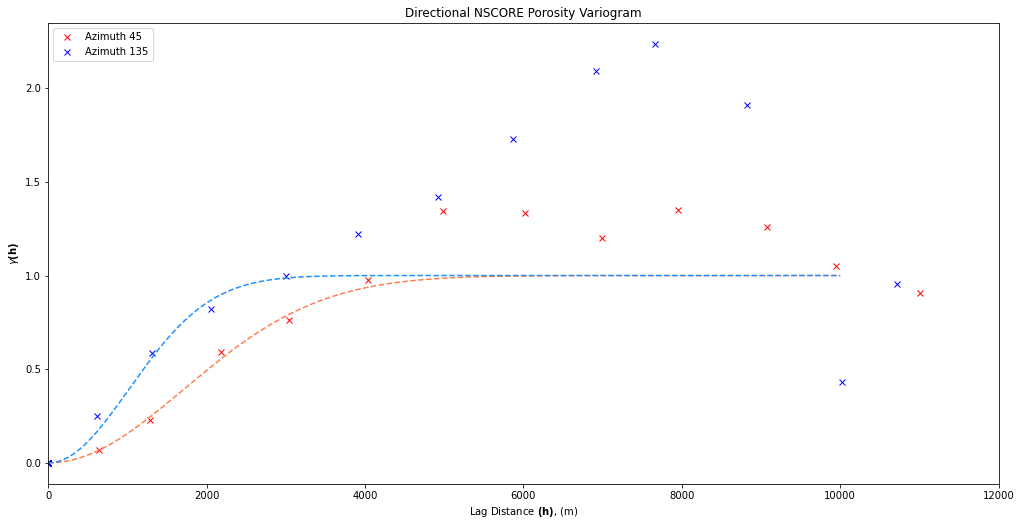

In [200]:
plt.subplot(1,1,1)
plt.plot(lag[2,:], gamma[2,:] ,'x', color = 'red', label = 'Azimuth ' + str(azi_mat[2]))
plt.plot(h45, gam45, color = 'coral', ls = '--')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,10000])
#plt.ylim([0,1.8])
plt.legend(loc='upper left')

#plt.subplot(1,2,2)
plt.plot(lag[6,:], gamma[6,:], 'x',color = 'blue',label = 'Azimuth ' +str(azi_mat[6]))
#plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135, gam135, color = 'dodgerblue', ls='--')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,12000])
#plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

# Kriging

Set up the parameters

In [179]:
print(study_grid.total_bounds)
#study_grid.plot()
print(df.head())

[ 267928.65280883 6085639.1498548   294237.16794663 6110819.45555515]
       Z          X           Y  decimal_long  neg_decimal_lat  predicted_z  \
0   4.09  268941.81  6093083.52    138.459534       -35.278757   -15.186636   
1   4.33  270906.82  6096136.56    138.481972       -35.251705     3.866074   
2  18.22  272506.29  6097255.78    138.499847       -35.241988    20.877973   
3   5.54  271897.13  6092138.11    138.491737       -35.287951    19.562934   
4  15.90  270438.32  6089954.64    138.475098       -35.307286     5.326878   

   residuals    Nresiduals  
0  19.276636  5.944087e-01  
1   0.463926 -1.490050e-08  
2  -2.657973 -7.489467e-02  
3 -14.022934 -3.039132e-01  
4  10.573122  1.881663e-01  


In [180]:
x1 = 260000
x2 = 300000
nx = 100
print("Len x: %i" %(x2-x1))

y1 = 6080000
y2 = 6120000
print("Len y: %i" %(y2-y1))
ny = 100

x_lin = np.linspace(x1, x2, nx+1)
#print(x_lin)
y_lin = np.linspace(y2, y1, ny+1)
#print(y_lin)

spacing_x = x_lin[1] - x_lin[0]
spacing_y = y_lin[1] - y_lin[0]

print(spacing_x)
print(spacing_y)

xx, yy = np.meshgrid(x_lin[:-1],
                     y_lin[:-1])

#zs = np.zeros_like(xx)

vmin = -70 #0
vmax = 70 #250

Len x: 40000
Len y: 40000
400.0
-400.0


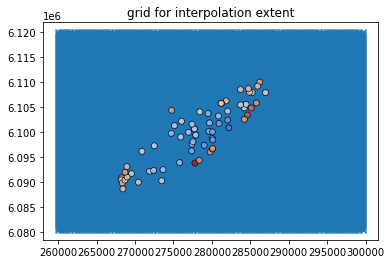

In [181]:
plt.scatter(xx.flatten(), yy.flatten(), marker="x")
plt.title("grid for interpolation extent")
im = plt.scatter(df["X"], df["Y"], s=None, c=df["residuals"], cmap="coolwarm", alpha=0.8, 
                 vmin=vmin, vmax=vmax, linewidths=0.8, edgecolors="black")

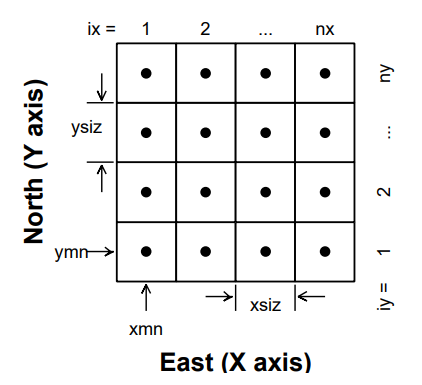

### For some reason the function breaks down if the search radius is too large

This is because of data in the same location - nested wells. Need to remove these.

In [182]:
skmean = df.residuals.mean()          # simple kriging mean (used if simple kriging is selected below)
ktype = 1                     # kriging type, 0 - simple, 1 - ordinary
isk = 0.0                     # Simple kriging with be performed with a mean of skmean if isk=0
radius = 5000 #10000                # search radius for neighbouring data
nxdis = 1                     # 1 = point kriging (not block kriging)
nydis = 1                     # 1 = point kriging (not block kriging)
ndmin = 1                     # minimum data for an estimate - min number of data able to be included in search
ndmax = 10                    # maximum data for an estimate - max number of data able to be included in search
tmin = -70                    # min property value
tmax = 70                     # max property value
nx = nx                       # number of cells x 
ny = ny                       # number of cells y
xmn = x1                      # grid origin, location center of lower left cell
ymn = y1                      # grid origin, location center of lower left cell
xsiz = int(spacing_x)                   # cell size
ysiz = abs(int(spacing_y))                   # cell size

# Use variogram from above

print(vario)

##vario = GSLIB.make_variogram(nug=nug, nst=nst, it1=it1, cc1=cc1, azi1=azi1, hmaj1=hmaj1, hmin1=hmin1) #  variogram

{'nug': 0.0, 'nst': 1, 'it1': 3, 'cc1': 1.0, 'azi1': 45, 'hmaj1': 4200, 'hmin1': 2500, 'it2': 1, 'cc2': 0, 'azi2': 0, 'hmaj2': 0, 'hmin2': 0}


Plot the kriged distributions

In [158]:
#df['residuals'].describe()

In [191]:
z_kmap, z_vmap = geostats.kb2d(df,'X','Y','Nresiduals', tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, nxdis, nydis,
                                 ndmin, ndmax, radius, ktype, skmean, vario)

  Estimated   10000 blocks 
      average   -0.3646729897011245  variance  63.56966744092139


In [192]:
z_kmap

array([[0.94769727, 0.94769727, 0.94769727, ..., 0.94769727, 0.94769727,
        0.94769727],
       [0.94769727, 0.94769727, 0.94769727, ..., 0.94769727, 0.94769727,
        0.94769727],
       [0.94769727, 0.94769727, 0.94769727, ..., 0.94769727, 0.94769727,
        0.94769727],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

(100, 100)
(100, 100)
(100, 100)
(100, 100)


Text(0.5, 1.0, 'Kriged variance - residuals')

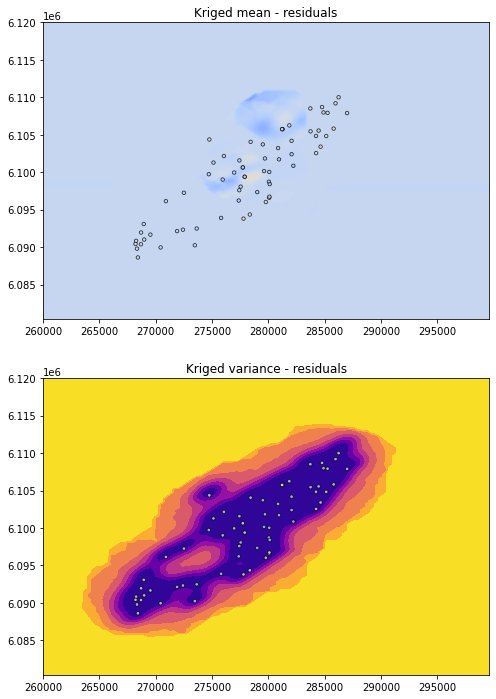

In [193]:
cmap = "coolwarm"
vmin = -250
vmax = 350

#print(xx)
print(np.shape(xx))
print(np.shape(yy))
print(np.shape(z_kmap))
print(np.shape(z_vmap))

plt.figure(figsize=(8,12))

# Plotting mean
plt.subplot(211)
cs = plt.contourf(xx, yy, z_kmap, cmap=cmap, vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))

im = plt.scatter(df["X"], df["Y"], s=12, c=df["residuals"], cmap=cmap, alpha=0.8, 
                 vmin=vmin, vmax=vmax, linewidths=0.8, edgecolors='k')


plt.title("Kriged mean - residuals")
#cbar = plt.colorbar(orientation = 'vertical', ticks=np.linspace(vmin,vmax,10))
#cbar.set_label("Head [m]", rotation=270, labelpad=20)

# Plotting variance
plt.subplot(212)
cs = plt.contourf(xx, yy, z_vmap, cmap="plasma")

im = plt.scatter(df["X"], df["Y"], s=12, c=df["residuals"], cmap=cmap, alpha=0.8, 
                 vmin=vmin, vmax=vmax, linewidths=0.8, edgecolors='k')

plt.title("Kriged variance - residuals")
#cbar = plt.colorbar(orientation = 'vertical')
#cbar.set_label("Variance [m]", rotation=270, labelpad=20)

### Predict linear trend onto the kriging grid

In [185]:
print(np.shape(study_grid_xy))
print(type(study_grid_xy))
#print(np.shape(xx), np.shape(yy))
#print(xx)
#print(x_lin)

xx_flat = xx.flatten(order='C')
yy_flat = yy.flatten(order='C')

a=[1,2,3]
b=[7,8,9]

kriging_grid = []
for i in range(len(xx_flat)):
    kriging_grid.append([xx_flat[i], yy_flat[i]])
    
#print(kriging_grid)
np.shape(kriging_grid)

kriging_grid_linear_trend = regr.predict(kriging_grid)
len(kriging_grid_linear_trend)
np.shape(kriging_grid_linear_trend)

(1074, 2)
<class 'list'>


(10000,)

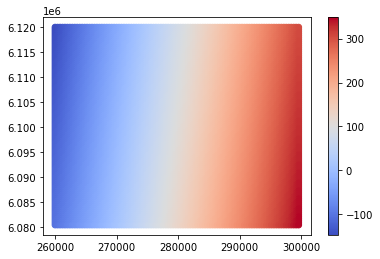

In [146]:
plt.scatter(*zip(*kriging_grid), c=kriging_grid_linear_trend, cmap='coolwarm')
plt.colorbar()

## Add linear trend to the residuals from the kriging

(100, 100)
(10000, 2)
(100, 100)


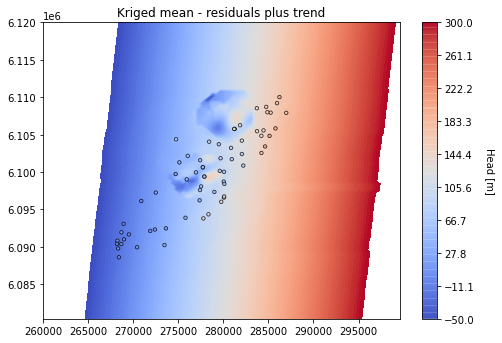

In [186]:
vmin = -50
vmax = 300

print(np.shape(z_kmap))
print(np.shape(kriging_grid))

kriging_grid_linear_trend_array = np.reshape(kriging_grid_linear_trend, (100,100))
print(np.shape(kriging_grid_linear_trend_array))

residuals_plus_trend = kriging_grid_linear_trend_array + z_kmap
np.shape(residuals_plus_trend)

plt.figure(figsize=(8,12))

# Plotting residuals plus trend
plt.subplot(211)
cs = plt.contourf(xx, yy, residuals_plus_trend, cmap=cmap, vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))

im = plt.scatter(df["X"], df["Y"], s=12, c=df["Z"], cmap=cmap, alpha=0.8, 
                 vmin=vmin, vmax=vmax, linewidths=0.8, edgecolors='k')


plt.title("Kriged mean - residuals plus trend")
cbar = plt.colorbar(orientation = 'vertical', ticks=np.linspace(vmin,vmax,10))
cbar.set_label("Head [m]", rotation=270, labelpad=20)


### Pull in the study extent

In [155]:
study_extent_file = os.path.join(outputdatapath,
                               "study_area_extent.shp")

study_extent_gdf = gpd.read_file(study_extent_file)

study_extent_gdf = study_extent_gdf.to_crs('epsg:32754')
study_extent_gdf.geometry

0    POLYGON ((267641.093 6085965.200, 267676.291 6...
Name: geometry, dtype: geometry

Plot with the study extent

<AxesSubplot:title={'center':'Kriged mean'}>

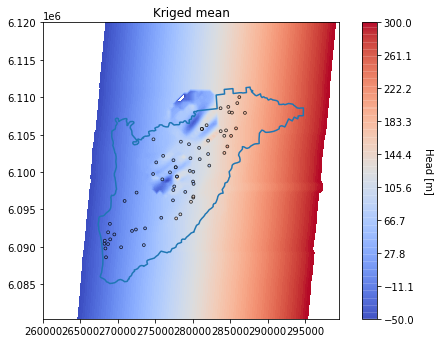

In [156]:

plt.figure(figsize=(8,12))

# Plotting mean
ax = plt.subplot(211)
cs = plt.contourf(xx, yy, residuals_plus_trend, cmap=cmap, vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))

im = plt.scatter(df["X"], df["Y"], s=8, c=df["Z"], cmap=cmap, alpha=0.8, 
                 vmin=vmin, vmax=vmax, linewidths=0.8, edgecolors="black")
cbar = plt.colorbar(im, orientation = 'vertical', ticks=np.linspace(vmin,vmax,10))

plt.title("Kriged mean")
cbar.set_label("Head [m]", rotation=270, labelpad=20)

study_extent_gdf.boundary.plot(ax=ax)




### Make new geodataframe with kriged results

I need to crop these three things:
xx, yy, z_kmap

The easiest way might be to turn the x, y, z and var values into a geodataframe. Other option would be to use rasterio to create a mask: https://gis.stackexchange.com/questions/357490/mask-xarray-dataset-using-a-shapefile

In [157]:
xx_flat = xx.flatten()
yy_flat = yy.flatten()
z_kmap_flat = z_kmap.flatten()
z_vmap_flat = z_vmap.flatten()
residuals_plus_trend_flat = residuals_plus_trend.flatten()

'''
print(len(xx_flat))
print(len(yy_flat))
print(len(z_kmap_flat))
print(len(z_vmap_flat))
'''
kriged_df = pd.DataFrame({"X": xx_flat,
                        "Y": yy_flat,
                        "mean_res": z_kmap_flat,
                        "var_res": z_vmap_flat,
                         "res_and_trend": residuals_plus_trend_flat,
                         "trend": kriging_grid_linear_trend})

kriged_gdf = gpd.GeoDataFrame(kriged_df, 
                              geometry=gpd.points_from_xy(kriged_df.X, kriged_df.Y), 
                              crs=study_extent_gdf.crs)
'''
print(kriged_gdf.columns)
print(kriged_gdf.index)
print(kriged_gdf['geometry'])
print("study extent")
print(study_extent_gdf['geometry'])
print(kriged_gdf.crs)
print(study_extent_gdf.crs)
'''

'\nprint(kriged_gdf.columns)\nprint(kriged_gdf.index)\nprint(kriged_gdf[\'geometry\'])\nprint("study extent")\nprint(study_extent_gdf[\'geometry\'])\nprint(kriged_gdf.crs)\nprint(study_extent_gdf.crs)\n'

### Crop results to study extent

In [150]:
kriged_gdf_sa = gpd.clip(kriged_gdf, study_extent_gdf)

In [151]:
kriged_gdf_sa.columns

Index(['X', 'Y', 'mean_res', 'var_res', 'res_and_trend', 'trend', 'geometry'], dtype='object')

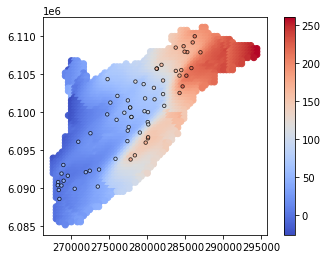

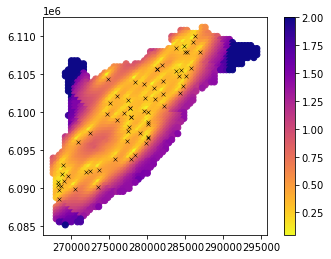

In [152]:
kriged_gdf_sa.plot(column='res_and_trend', cmap="coolwarm", legend=True)

im = plt.scatter(df["X"], df["Y"], s=12, c=df["Z"], cmap=cmap, alpha=0.8, 
                 vmin=vmin, vmax=vmax, linewidths=0.8, edgecolors='k')


kriged_gdf_sa.plot(column='var_res', cmap="plasma_r", legend=True)

im = plt.scatter(df["X"], df["Y"], s=15, marker="x",
                 linewidths=0.5, c='k')


# Below this -- IGNORE !

In [166]:
print(z_kmap)
print(np.max(z_kmap))
print(np.size(z_kmap))
print(np.shape(z_kmap))

[[79.45616438 79.45616438 79.45616438 ... 79.45616438 79.45616438
  79.45616438]
 [79.45616438 79.45616438 79.45616438 ... 79.45616438 79.45616438
  79.45616438]
 [79.45616438 79.45616438 79.45616438 ... 79.45616438 79.45616438
  79.45616438]
 ...
 [79.45616438 79.45616438 79.45616438 ... 79.45616438 79.45616438
  79.45616438]
 [79.45616438 79.45616438 79.45616438 ... 79.45616438 79.45616438
  79.45616438]
 [79.45616438 79.45616438 79.45616438 ... 79.45616438 79.45616438
  79.45616438]]
194.54820830913332
10000
(100, 100)


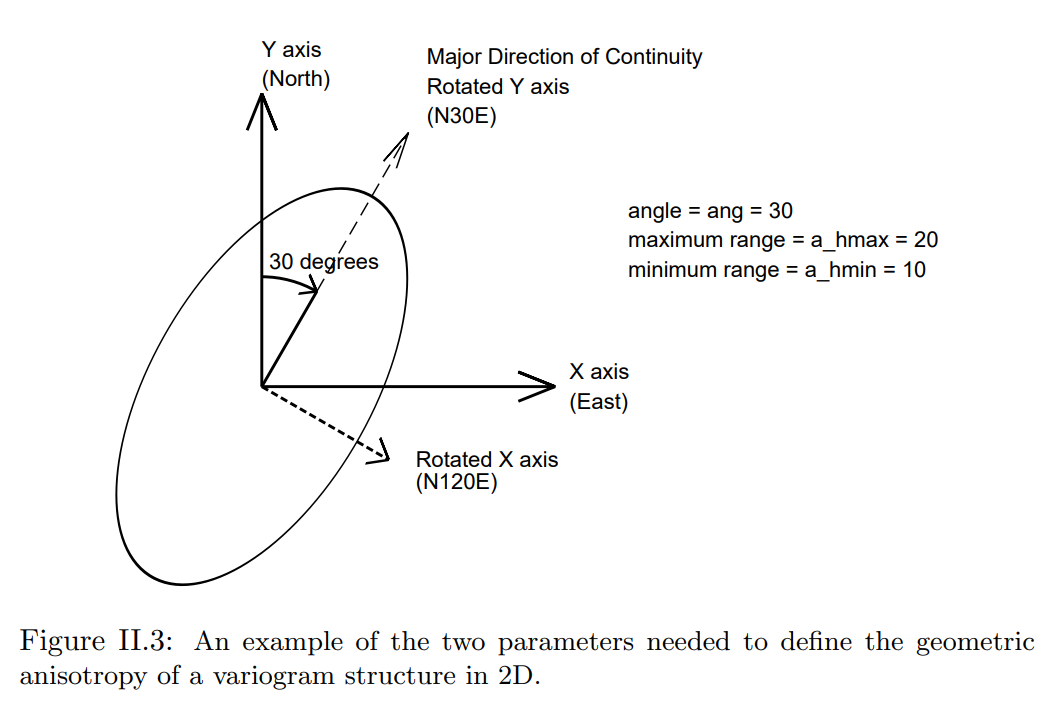


## Breaking down the kriging function

So I can see what is going wrong. This is from geostatpy package in C:\Users\mar886\Anaconda3\envs\geostats_env\Lib\site-packages\geostatspy 

In [182]:
print("df is: %s" %df.head(2))
xcol = "X"
ycol = "Y"
vcol = "Z"


# Constants
UNEST = -999.
EPSLON = 1.0e-10
VERSION = 2.907
first = True
PMX = 9999.0    
MAXSAM = ndmax + 1       # Maximum no. samples for kriging
MAXDIS = nxdis * nydis   # Maximum no. of discretisation points for a block
MAXKD = MAXSAM + 1       # 
MAXKRG = MAXKD * MAXKD   #

df is:       Z          X           Y  decimal_long  neg_decimal_lat  predicted_z  \
0  4.09  268941.81  6093083.52    138.459534       -35.278757   -17.537986   
1  4.33  270906.82  6096136.56    138.481972       -35.251705     1.376692   

   residuals  Nresiduals  
0  21.627986    0.663752  
1   2.953308    0.137784  


### Load the variogram

In [183]:
nst = vario['nst']


cc = np.zeros(nst)
aa = np.zeros(nst)
it = np.zeros(nst)
ang = np.zeros(nst)
anis = np.zeros(nst)
c0 = vario['nug']

cc[0] = vario['cc1']
it[0] = vario['it1']
ang[0] = vario['azi1']

aa[0] = vario['hmaj1']
anis[0] = vario['hmin1']/vario['hmaj1']

if nst == 2:
    cc[1] = vario['cc2']
    it[1] = vario['it2']
    ang[1] = vario['azi2'] 
    aa[1] = vario['hmaj2']
    anis[1] = vario['hmin2']/vario['hmaj2']

### Allocate the needed memory

In [184]:
xdb = np.zeros(MAXDIS)
ydb = np.zeros(MAXDIS)
xa = np.zeros(MAXSAM)
ya = np.zeros(MAXSAM)
vra = np.zeros(MAXSAM)
dist = np.zeros(MAXSAM)
nums = np.zeros(MAXSAM)
r = np.zeros(MAXKD)
rr = np.zeros(MAXKD)
s = np.zeros(MAXKD)
a = np.zeros(MAXKRG)
kmap = np.zeros((ny,nx))
vmap = np.zeros((ny,nx))

In [185]:
print(a)
print(type(a))
print(np.size(a))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<class 'numpy.ndarray'>
144


### Load the data

In [186]:
    
df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
nd = len(df_extract)
ndmax = min(ndmax,nd)
x = df_extract[xcol].values
y = df_extract[ycol].values
vr = df_extract[vcol].values
    

### Make a KDTree for fast search of nearest neighbours 

Info on tree here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html

This class provides an index into a set of k-dimensional points which can be used to rapidly look up the nearest neighbors of any point.

leafsize=The number of points at which the algorithm switches over to brute force (??) Default is 10, value from GeoStatsGuy = 16

In [187]:
import scipy.spatial as sp  # for fast nearest neighbor search


dp = list((y[i], x[i]) for i in range(0,nd))
data_locs = np.column_stack((y,x))
tree = sp.cKDTree(data_locs, leafsize=1000, compact_nodes=True, copy_data=False, balanced_tree=True)

### Summary statistics for the data after trimming

In [188]:
avg = vr.mean()
stdev = vr.std()
ss = stdev**2.0   # SM - this is the variance?
vrmin = vr.min()
vrmax = vr.max()   

    
### Set up the discretization points per block

Figure out how many are needed, the spacing, and fill the xdb and ydb arrays with the offsets relative to the block center (this only gets done once)


This is helpful if you have a really large sized array and want to break it down into blocks instead of every single node -> however I will be just using every node

In [195]:
ndb  = nxdis * nydis    

print("ndb: %i" %ndb)

if ndb > MAXDIS: 
    print('ERROR KB2D: Too many discretization points ')
    print('            Increase MAXDIS or lower n[xy]dis')
    #return kmap -- Sarah  has commented out this line...don't understand the return statement here?
    
xdis = xsiz  / max(float(nxdis),1.0)
print("xdis: %i" %xdis)
ydis = ysiz  / max(float(nydis),1.0)
print("ydis: %i" %ydis)
xloc = -0.5*(xsiz+xdis)
print("xloc: %i" %xloc)

i    = -1   # accounting for 0 as lowest index

for ix in range(0,nxdis):       
    xloc = xloc + xdis
    yloc = -0.5*(ysiz+ydis)
    for iy in range(0,nydis): 
        yloc = yloc + ydis
        i = i+1
        xdb[i] = xloc
        ydb[i] = yloc
        
print(ydb)

ndb: 1
xdis: 400
ydis: 400
xloc: -400
[0.]


### Initialize accumulators

In [196]:
cbb  = 0.0
rad2 = radius*radius    

### Calculate Block Covariance. Check for point kriging.

Re-initialise the cosine matrix for the variogram structures

In [198]:
rotmat, maxcov = geostats.setup_rotmat(c0, nst, it, cc, ang, PMX)

print(rotmat)
print(maxcov)

[[ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [-0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
1.0


In [199]:
cov = geostats.cova2(xdb[0], ydb[0], xdb[0], ydb[0], nst, c0, PMX, 
                     cc, aa, it, ang, anis, rotmat, maxcov)
print(cov)

1.0


### Keep this value to use for the unbiasedness constraint

In [200]:
unbias = cov
first  = False
if ndb <= 1:
    cbb = cov
else:
    for i in range(0,ndb): 
        for j in range(0,ndb): 
            cov = geostats.cova2(xdb[i],ydb[i],xdb[j],ydb[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
        if i == j: 
            cov = cov - c0
        cbb = cbb + cov
    cbb = cbb/real(ndb*ndb)

### MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:

In [201]:
nk = 0
ak = 0.0
vk = 0.0

xlocs = []
ylocs = []
current_nodes = []

for iy in range(0,ny):
    yloc = ymn + (iy-0)*ysiz 
    ylocs.append(yloc)
    for ix in range(0,nx):
        xloc = xmn + (ix-0)*xsiz
        xlocs.append(xloc)
        current_node = (yloc,xloc)
        current_nodes.append(current_node)
        

## TEST SPECIFIC NODES

In [203]:
#print(xlocs)
#print(ylocs)
iys = range(0,ny)
iy = 49 #iys[0]
print("iy: %i" %iy)
ixs = range(0,nx)
ix = 45 #ixs[0]
print("ix: %i" %ix)
yloc = ymn + (iy-0)*ysiz 
print("yloc: %i" %yloc)
xloc = xmn + (ix-0)*xsiz
print("xloc: %i" %xloc)
current_node = (yloc,xloc)
print("current node: %s" % (current_node,))

iy: 49
ix: 45
yloc: 6099600
xloc: 278000
current node: (6099600, 278000)


In [206]:
# Find the nearest samples within each octant: First initialize
# the counter arrays:
na = -1   # accounting for 0 as first index
#print(na)
dist.fill(1.0e+20)
#print(dist)
nums.fill(-1)
#print(nums)

[1.e+20 1.e+20 1.e+20 1.e+20 1.e+20]
[-1 -1 -1 -1 -1]


value for iy:8 ix:8
10
10
[11936.27480753 12752.47829339 13154.90704675 13427.70215166
 13511.26828077 14096.07801807 14310.95064459 14674.00201343
 14953.42123594 15736.04807016]
[11  8  7  9  6 10  4 12  5  0]

In [207]:
dist, nums = tree.query(current_node, ndmax) # use kd tree for fast nearest data search

print(len(dist))
print(len(nums))
print(dist)
print(nums)

10
10
[ 228.12760026  228.12760026  228.12760026  228.12760026  229.05580303
 1073.58303549 1073.58303549 1073.58303549 1073.58303549 1073.86711366]
[60 59 62 61 54 57 55 56 58 53]


In [208]:
# remove any data outside search radius
na = len(dist)
nums = nums[dist<radius]
dist = dist[dist<radius] 
na = len(dist)  
print(dist)
print(nums)

[228.12760026 228.12760026 228.12760026 228.12760026 229.05580303]
[60 59 62 61 54]


In [209]:
# Is there enough samples?
print(ndmin)
print("na: %i" %na)
print(na + 1)
print(na + 1 < ndmin)
print(ktype)

1
na: 5
6
False
0


In [210]:
print(nums)
jj = int(nums[ia])
print(jj)
print(len(x))
print(len(df))
print(y)
print(na)

[60 59 62 61 54]
54
73
73
[6093083.52 6096136.56 6097255.78 6092138.11 6089954.64 6091667.15
 6090831.55 6090420.49 6089793.53 6090381.57 6091011.04 6088616.53
 6091952.55 6090244.52 6093805.56 6096025.56 6097347.3  6101288.74
 6101840.75 6104194.56 6107901.46 6107931.76 6105829.25 6102164.52
 6104373.48 6104055.05 6108522.45 6110008.68 6109203.72 6099024.54
 6104842.78 6099957.87 6096220.52 6103716.5  6100153.55 6101721.53
 6098728.49 6098418.56 6097596.19 6100862.53 6098076.46 6105562.62
 6102406.47 6100037.46 6105457.   6103228.91 6107988.55 6099737.57
 6092481.48 6106253.5  6108702.51 6096593.29 6103416.13 6100639.57
 6099395.55 6100638.5  6100638.5  6100638.5  6100638.5  6099396.56
 6099396.56 6099396.56 6099396.56 6093895.2  6092324.5  6101578.42
 6096736.5  6104832.29 6094351.48 6102553.08 6105752.37 6105754.58
 6105755.3 ]
5


In [211]:
if na + 1 < ndmin:   # accounting for min index of 0
    print("Not enough samples")
    est  = UNEST
    estv = UNEST
    print('UNEST at ' + str(ix) + ',' + str(iy))
else:
    print("There are enough samples")
    # Put coordinates and values of neighborhood samples into xa,ya,vra:
    for ia in range(0, na):
        print("ia: %i" %ia)
        jj = int(nums[ia])   #SM nums I think are the indexes of the values within search radius (neighbourhood samples) 
        print("jj: %i" %jj)
        xa[ia]  = x[jj]      # Add coordinates of neighbourhood samples
        print("x: %i" %x[jj] )
        ya[ia]  = y[jj]      # Add coordinates of neighbourhood samples
        print("y: %i" %y[jj])
        vra[ia] = vr[jj]     # Add x values of neighbourhood samples
        print("v: %i" %vr[jj])
        
print(xa)
print(ya)
print(vra)

There are enough samples
ia: 0
jj: 60
x: 277896
y: 6099396
v: 54
ia: 1
jj: 59
x: 277896
y: 6099396
v: 54
ia: 2
jj: 62
x: 277896
y: 6099396
v: 54
ia: 3
jj: 61
x: 277896
y: 6099396
v: 54
ia: 4
jj: 54
x: 277896
y: 6099395
v: 55
[277896.78 277896.78 277896.78 277896.78 277896.72      0.        0.
      0.        0.        0.        0.  ]
[6099396.56 6099396.56 6099396.56 6099396.56 6099395.55       0.
       0.         0.         0.         0.         0.  ]
[54.72 54.78 54.34 54.32 55.44  0.    0.    0.    0.    0.    0.  ]


## I'm not sure why there is an empty value at the end?? Check if this is always the case, it looks set up that way...

### This is the line (from the code below) that seems to be making a non-invertable matrix,
the question is why is this one non-invertable when the others are not?


In [212]:
iin=-1 # accounting for first index of 0
print(a)

for i in range(0, na):  # was j - want full matrix                    
    iin = iin + 1 # SM Indexing starting at 0
    print(iin)
    covvalue = geostats.cova2(xa[i], ya[i], xa[j], ya[j], nst, c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov) 
    print(covvalue)
    
    #This line below is making non-invertable matrix, so I am playing with this code
    a[iin] = geostats.cova2(xa[i], ya[i], xa[j], ya[j], nst, c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov) 
print(a)

[1.         1.         1.         1.         0.99904108 1.
 1.         1.         1.         0.99904108 1.         1.
 1.         1.         0.99904108 1.         1.         1.
 1.         0.99904108 0.99904108 0.99904108 0.99904108 0.99904108
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

# Is this issue just because my search radius is too big so when I get in the middle the covariance is the same for each different..

In [213]:
print(list(range(0, na)))

[0, 1, 2, 3, 4]


In [214]:
        
# Handle the situation of only one sample:
    if na == 0:  # accounting for min index of 0 - one sample case na = 0
        print("There is only one sample")
        cb1 = geostats.cova2(xa[0],ya[0],xa[0],ya[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
        xx  = xa[0] - xloc
        yy  = ya[0] - yloc
        
# Establish Right Hand Side Covariance with only one sample:
        if ndb <= 1:
            cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
        else:
            cb  = 0.0
            for i in range(0,ndb):                  
                cb = cb + geostats.cova2(xx,yy,xdb[i],ydb[i],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                dx = xx - xdb(i)
                dy = yy - ydb(i)
                if (dx*dx+dy*dy) < EPSLON:
                    cb = cb - c0
                cb = cb / real(ndb)
        if ktype == 0:
            s[0] = cb/cbb
            est  = s[0]*vra[0] + (1.0-s[0])*skmean
            estv = cbb - s[0] * cb
        else:
            est  = vra[0]
            estv = cbb - 2.0*cb + cb1
    else:
# Solve the Kriging System with more than one sample:
        neq = na + ktype # accounting for first index of 0
#                    print('NEQ' + str(neq))
        nn  = (neq + 1)*neq/2
    
# Set up kriging matrices:
        iin=-1 # accounting for first index of 0
        for j in range(0,na):
            
# Establish Left Hand Side Covariance Matrix:
            for i in range(0,na):  # was j - want full matrix                    
                iin = iin + 1 # SM Indexing starting at 0
                a[iin] = geostats.cova2(xa[i], ya[i], xa[j], ya[j], nst, c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov) 
                print("Made a")
            if ktype == 1:
                iin = iin + 1
                a[iin] = unbias
            xx = xa[j] - xloc
            yy = ya[j] - yloc
            

# Establish Right Hand Side Covariance:
            if ndb <= 1:
                cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
            else:
                cb  = 0.0
                for j1 in range(0,ndb):    
                    cb = cb + geostats.cova2(xx,yy,xdb[j1],ydb[j1],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    dx = xx - xdb[j1]
                    dy = yy - ydb[j1]
                    if (dx*dx+dy*dy) < EPSLON:
                        cb = cb - c0
                cb = cb / real(ndb)
            r[j]  = cb
            rr[j] = r[j]
            
# Set the unbiasedness constraint:
        if ktype == 1:
            for i in range(0,na):
                iin = iin + 1
                a[iin] = unbias
            iin      = iin + 1
            a[iin]   = 0.0
            r[neq-1]  = unbias
            rr[neq-1] = r[neq]

Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a
Made a


### This is where the issue lies

I am unable to invert a for this issue


In [215]:
print(neq)
#print(a)
print(type(a))
print(np.shape(a))
print(type(r))
print(r)
print(np.shape(r))

5
<class 'numpy.ndarray'>
(144,)
<class 'numpy.ndarray'>
[0.89296698 0.89296698 0.89296698 0.89296698 0.89246851 0.
 0.         0.         0.         0.         0.         0.        ]
(12,)


# To get a with and without issue 

I first ran from  ## TEST SPECIFIC NODES ABOVE TO HERE THEN SAVED THE MATRIX WITH AND WITHOUT ISSUE:

Without issue: any index (I used 8,8)
With issue: final index (9,9) when grid size is 1900

In [216]:
import numpy.linalg as linalg  # for linear algebra


a = a[0: neq * neq]  # trim the array
a = np.reshape(a, (neq, neq))  # reshape to 2D
#ainv = linalg.inv(a)  # invert matrix

In [217]:
a_with_issue = a
#a_without_issue = a

#a_ix9_iy9 = a
#a_ix8_iy8 = a

### Why is the determinant of this matrix 0?

In [218]:
print(np.linalg.det(a_with_issue))

0.0


In [906]:
print(np.linalg.det(a_ix8_iy8))

0.0012999569042515466


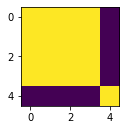

In [219]:
plt.figure()
plt.subplot(211)
plt.imshow(a_with_issue)
#plt.subplot(212)
#plt.imshow(a_ix9_iy9)

In [220]:
ainv1 = linalg.inv(a_with_issue)  # invert matrix
print("Inverted first")

ainv2 = linalg.inv(a_ix9_iy9)  # invert matrix
print("Inverted second")

LinAlgError: Singular matrix

In [910]:
print(a_ix9_iy9)
print(type(a_ix9_iy9))
print(np.shape(a_ix9_iy9))

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [4.99486493e-01 4.99486493e-01 4.99486493e-01 4.99486493e-01
  4.99486493e-01 4.99486493e-01 4.99486493e-01 4.99486493e-01
  4.99486493e-01 4.99486493e-01]
 [2.93383803e-01 2.93383803e-01 2.93383803e-01 2.93383803e-01
  2.93383803e-01 2.93383803e-01 2.93383803e-01 2.93383803e-01
  2.93383803e-01 2.93383803e-01]
 [4.10969844e-01 4.10969844e-01 4.10969844e-01 4.10969844e-01
  4.10969844e-01 4.10969844e-01 4.10969844e-01 4.10969844e-01
  4.10969844e-01 4.10969844e-01]
 [2.06284057e-01 2.06284057e-01 2.06284057e-01 2.06284057e-01
  2.06284057e-01 2.06284057e-01 2.06284057e-01 2.06284057e-01
  2.06284057e-01 2.06284057e-01]
 [3.01025301e-01 3.01025301e-01 3.01025301e-01 3.01025301e-01
  3.01025301e-01 3.01025301e-01 3.01025301e-01 3.01025301e-01
  3.01025301e-01 3.01025301e-01]
 [5.24578236e-01 5.24578236e-01 5.24578236e-01 5.24578236e

In [221]:
s = geostats.ksol_numpy(neq,a,r)


LinAlgError: Singular matrix

In [ ]:

def ksol_numpy(neq, a, r):
    """Find solution of a system of linear equations.
    :param neq: number of equations
    :param a: upper triangular left hand side matrix
    :param r: right hand side matrix
    :return: solution array, same dimension as `r`
    """
    a = a[0: neq * neq]  # trim the array
    a = np.reshape(a, (neq, neq))  # reshape to 2D
    ainv = linalg.inv(a)  # invert matrix
    r = r[0: neq]  # trim the array
    s = np.matmul(ainv, r)  # matrix multiplication
    return s

In [ ]:
# Solve the Kriging System:
#                    print('NDB' + str(ndb))
#                    print('NEQ' + str(neq) + ' Left' + str(a) + ' Right' + str(r))
#                    stop
        s = geostats.ksol_numpy(neq,a,r)
        ising = 0 # need to figure this out
#                    print('weights' + str(s))
#                    stop

# Write a warning if the matrix is singular:
        if ising != 0:
            print('WARNING KB2D: singular matrix')
            print('              for block' + str(ix) + ',' + str(iy)+ ' ')
            est  = UNEST
            estv = UNEST
        else:
            print("Not singular")

# Compute the estimate and the kriging variance:
            est  = 0.0
            estv = cbb
            sumw = 0.0
            if ktype == 1: 
                estv = estv - (s[na])*unbias
            for i in range(0,na):                          
                sumw = sumw + s[i]
                est  = est  + s[i]*vra[i]
                estv = estv - s[i]*rr[i]
            if ktype == 0: 
                est = est + (1.0-sumw)*skmean
                
kmap[ny-iy-1,ix] = est
vmap[ny-iy-1,ix] = estv
if est > UNEST:
    nk = nk + 1
    ak = ak + est
    vk = vk + est*est
    
if nk >= 1:
    ak = ak / float(nk)
    vk = vk/float(nk) - ak*ak
    print('  Estimated   '   + str(nk) + ' blocks ')
    print('      average   ' + str(ak) + '  variance  ' + str(vk))

In [656]:
print(na)
print(ndb)
print(cb)
print(neq)
print(ktype)
print(xx)
print(yy)
print(s)
print(ising != 0)
print(ising)

10
1
0.3880430332608429
10
0
-2782.2000000000116
-2875.5
[ 0.081206    0.19317474 -0.03240137  0.12647368  0.24960091 -0.02144468
 -0.00083892  0.10430328  0.00345117  0.24689746]
False
0


### Main loop below

In [202]:
for iy in range(0,ny):
    yloc = ymn + (iy-0)*ysiz  
    for ix in range(0,nx):
        print(print("ix, iy: %i, %i" %(ix,iy)))
        xloc = xmn + (ix-0)*xsiz
        current_node = (yloc,xloc)
        print("current node %s" %(current_node,))
        
# Find the nearest samples within each octant: First initialize
# the counter arrays:
        na = -1   # accounting for 0 as first index
        dist.fill(1.0e+20)
        nums.fill(-1)
        dist, nums = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
        # remove any data outside search radius
        na = len(dist)
        nums = nums[dist<radius]
        dist = dist[dist<radius] 
        na = len(dist)        
        print("1")

# Is there enough samples?
        if na + 1 < ndmin:   # accounting for min index of 0
            est  = UNEST
            estv = UNEST
            print('UNEST at ' + str(ix) + ',' + str(iy))
        else:

# Put coordinates and values of neighborhood samples into xa,ya,vra:
            for ia in range(0,na):
                jj = int(nums[ia])
                xa[ia]  = x[jj]
                ya[ia]  = y[jj]
                vra[ia] = vr[jj]
                #print("2")

# Handle the situation of only one sample:
            if na == 0:  # accounting for min index of 0 - one sample case na = 0
                cb1 = geostats.cova2(xa[0],ya[0],xa[0],ya[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                xx  = xa[0] - xloc
                yy  = ya[0] - yloc
                print("3")

# Establish Right Hand Side Covariance:
                if ndb <= 1:
                    cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    print("4")
                else:
                    cb  = 0.0
                    for i in range(0,ndb):                  
                        cb = cb + geostats.cova2(xx,yy,xdb[i],ydb[i],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                        dx = xx - xdb(i)
                        dy = yy - ydb(i)
                        if (dx*dx+dy*dy) < EPSLON:
                            cb = cb - c0
                        cb = cb / real(ndb)
                if ktype == 0:
                    s[0] = cb/cbb
                    est  = s[0]*vra[0] + (1.0-s[0])*skmean
                    estv = cbb - s[0] * cb
                    print("5")
                else:
                    est  = vra[0]
                    estv = cbb - 2.0*cb + cb1
                    print("6")
            else:
                print("7")

# Solve the Kriging System with more than one sample:
                neq = na + ktype # accounting for first index of 0
#                    print('NEQ' + str(neq))
                nn  = (neq + 1)*neq/2

# Set up kriging matrices:
                iin=-1 # accounting for first index of 0
                for j in range(0,na):

# Establish Left Hand Side Covariance Matrix:
                    for i in range(0,na):  # was j - want full matrix                    
                        iin = iin + 1
                        a[iin] = geostats.cova2(xa[i],ya[i],xa[j],ya[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov) 
                    if ktype == 1:
                        iin = iin + 1
                        a[iin] = unbias
                    xx = xa[j] - xloc
                    yy = ya[j] - yloc

# Establish Right Hand Side Covariance:
                    if ndb <= 1:
                        cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    else:
                        cb  = 0.0
                        for j1 in range(0,ndb):    
                            cb = cb + geostats.cova2(xx,yy,xdb[j1],ydb[j1],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                            dx = xx - xdb[j1]
                            dy = yy - ydb[j1]
                            if (dx*dx+dy*dy) < EPSLON:
                                cb = cb - c0
                        cb = cb / real(ndb)
                    r[j]  = cb
                    rr[j] = r[j]

# Set the unbiasedness constraint:
                if ktype == 1:
                    for i in range(0,na):
                        iin = iin + 1
                        a[iin] = unbias
                    iin      = iin + 1
                    a[iin]   = 0.0
                    r[neq-1]  = unbias
                    rr[neq-1] = r[neq]

# Solve the Kriging System: 88
#                    print('NDB' + str(ndb))
#                    print('NEQ' + str(neq) + ' Left' + str(a) + ' Right' + str(r))
#                    stop
                print("9")
                s = geostats.ksol_numpy(neq,a,r)
                print("9a")
                ising = 0 # need to figure this out
#                    print('weights' + str(s))
#                    stop


# Write a warning if the matrix is singular:
                if ising != 0:
                    print("10")
                    print('WARNING KB2D: singular matrix')
                    print('              for block' + str(ix) + ',' + str(iy)+ ' ')
                    est  = UNEST
                    estv = UNEST
                else:
                    print("11")

# Compute the estimate and the kriging variance:
                    est  = 0.0
                    estv = cbb
                    sumw = 0.0
                    if ktype == 1: 
                        estv = estv - (s[na])*unbias
                    for i in range(0,na):                          
                        sumw = sumw + s[i]
                        est  = est  + s[i]*vra[i]
                        estv = estv - s[i]*rr[i]
                    if ktype == 0: 
                        est = est + (1.0-sumw)*skmean
        kmap[ny-iy-1,ix] = est
        vmap[ny-iy-1,ix] = estv
        if est > UNEST:
            nk = nk + 1
            ak = ak + est
            vk = vk + est*est

# END OF MAIN LOOP OVER ALL THE BLOCKS:
     

ix, iy: 0, 0
None
current node (6080000, 260000)
1
3
4
5
ix, iy: 1, 0
None
current node (6080000, 260400)
1
3
4
5
ix, iy: 2, 0
None
current node (6080000, 260800)
1
3
4
5
ix, iy: 3, 0
None
current node (6080000, 261200)
1
3
4
5
ix, iy: 4, 0
None
current node (6080000, 261600)
1
3
4
5
ix, iy: 5, 0
None
current node (6080000, 262000)
1
3
4
5
ix, iy: 6, 0
None
current node (6080000, 262400)
1
3
4
5
ix, iy: 7, 0
None
current node (6080000, 262800)
1
3
4
5
ix, iy: 8, 0
None
current node (6080000, 263200)
1
3
4
5
ix, iy: 9, 0
None
current node (6080000, 263600)
1
3
4
5
ix, iy: 10, 0
None
current node (6080000, 264000)
1
3
4
5
ix, iy: 11, 0
None
current node (6080000, 264400)
1
3
4
5
ix, iy: 12, 0
None
current node (6080000, 264800)
1
3
4
5
ix, iy: 13, 0
None
current node (6080000, 265200)
1
3
4
5
ix, iy: 14, 0
None
current node (6080000, 265600)
1
3
4
5
ix, iy: 15, 0
None
current node (6080000, 266000)
1
3
4
5
ix, iy: 16, 0
None
current node (6080000, 266400)
1
3
4
5
ix, iy: 17, 0
None
curre

1
3
4
5
ix, iy: 67, 4
None
current node (6081600, 286800)
1
3
4
5
ix, iy: 68, 4
None
current node (6081600, 287200)
1
3
4
5
ix, iy: 69, 4
None
current node (6081600, 287600)
1
3
4
5
ix, iy: 70, 4
None
current node (6081600, 288000)
1
3
4
5
ix, iy: 71, 4
None
current node (6081600, 288400)
1
3
4
5
ix, iy: 72, 4
None
current node (6081600, 288800)
1
3
4
5
ix, iy: 73, 4
None
current node (6081600, 289200)
1
3
4
5
ix, iy: 74, 4
None
current node (6081600, 289600)
1
3
4
5
ix, iy: 75, 4
None
current node (6081600, 290000)
1
3
4
5
ix, iy: 76, 4
None
current node (6081600, 290400)
1
3
4
5
ix, iy: 77, 4
None
current node (6081600, 290800)
1
3
4
5
ix, iy: 78, 4
None
current node (6081600, 291200)
1
3
4
5
ix, iy: 79, 4
None
current node (6081600, 291600)
1
3
4
5
ix, iy: 80, 4
None
current node (6081600, 292000)
1
3
4
5
ix, iy: 81, 4
None
current node (6081600, 292400)
1
3
4
5
ix, iy: 82, 4
None
current node (6081600, 292800)
1
3
4
5
ix, iy: 83, 4
None
current node (6081600, 293200)
1
3
4
5
ix, iy

current node (6083600, 286400)
1
3
4
5
ix, iy: 67, 9
None
current node (6083600, 286800)
1
3
4
5
ix, iy: 68, 9
None
current node (6083600, 287200)
1
3
4
5
ix, iy: 69, 9
None
current node (6083600, 287600)
1
3
4
5
ix, iy: 70, 9
None
current node (6083600, 288000)
1
3
4
5
ix, iy: 71, 9
None
current node (6083600, 288400)
1
3
4
5
ix, iy: 72, 9
None
current node (6083600, 288800)
1
3
4
5
ix, iy: 73, 9
None
current node (6083600, 289200)
1
3
4
5
ix, iy: 74, 9
None
current node (6083600, 289600)
1
3
4
5
ix, iy: 75, 9
None
current node (6083600, 290000)
1
3
4
5
ix, iy: 76, 9
None
current node (6083600, 290400)
1
3
4
5
ix, iy: 77, 9
None
current node (6083600, 290800)
1
3
4
5
ix, iy: 78, 9
None
current node (6083600, 291200)
1
3
4
5
ix, iy: 79, 9
None
current node (6083600, 291600)
1
3
4
5
ix, iy: 80, 9
None
current node (6083600, 292000)
1
3
4
5
ix, iy: 81, 9
None
current node (6083600, 292400)
1
3
4
5
ix, iy: 82, 9
None
current node (6083600, 292800)
1
3
4
5
ix, iy: 83, 9
None
current node (

current node (6085600, 286400)
1
3
4
5
ix, iy: 67, 14
None
current node (6085600, 286800)
1
3
4
5
ix, iy: 68, 14
None
current node (6085600, 287200)
1
3
4
5
ix, iy: 69, 14
None
current node (6085600, 287600)
1
3
4
5
ix, iy: 70, 14
None
current node (6085600, 288000)
1
3
4
5
ix, iy: 71, 14
None
current node (6085600, 288400)
1
3
4
5
ix, iy: 72, 14
None
current node (6085600, 288800)
1
3
4
5
ix, iy: 73, 14
None
current node (6085600, 289200)
1
3
4
5
ix, iy: 74, 14
None
current node (6085600, 289600)
1
3
4
5
ix, iy: 75, 14
None
current node (6085600, 290000)
1
3
4
5
ix, iy: 76, 14
None
current node (6085600, 290400)
1
3
4
5
ix, iy: 77, 14
None
current node (6085600, 290800)
1
3
4
5
ix, iy: 78, 14
None
current node (6085600, 291200)
1
3
4
5
ix, iy: 79, 14
None
current node (6085600, 291600)
1
3
4
5
ix, iy: 80, 14
None
current node (6085600, 292000)
1
3
4
5
ix, iy: 81, 14
None
current node (6085600, 292400)
1
3
4
5
ix, iy: 82, 14
None
current node (6085600, 292800)
1
3
4
5
ix, iy: 83, 14
No

1
3
4
5
ix, iy: 83, 19
None
current node (6087600, 293200)
1
3
4
5
ix, iy: 84, 19
None
current node (6087600, 293600)
1
3
4
5
ix, iy: 85, 19
None
current node (6087600, 294000)
1
3
4
5
ix, iy: 86, 19
None
current node (6087600, 294400)
1
3
4
5
ix, iy: 87, 19
None
current node (6087600, 294800)
1
3
4
5
ix, iy: 88, 19
None
current node (6087600, 295200)
1
3
4
5
ix, iy: 89, 19
None
current node (6087600, 295600)
1
3
4
5
ix, iy: 90, 19
None
current node (6087600, 296000)
1
3
4
5
ix, iy: 91, 19
None
current node (6087600, 296400)
1
3
4
5
ix, iy: 92, 19
None
current node (6087600, 296800)
1
3
4
5
ix, iy: 93, 19
None
current node (6087600, 297200)
1
3
4
5
ix, iy: 94, 19
None
current node (6087600, 297600)
1
3
4
5
ix, iy: 95, 19
None
current node (6087600, 298000)
1
3
4
5
ix, iy: 96, 19
None
current node (6087600, 298400)
1
3
4
5
ix, iy: 97, 19
None
current node (6087600, 298800)
1
3
4
5
ix, iy: 98, 19
None
current node (6087600, 299200)
1
3
4
5
ix, iy: 99, 19
None
current node (6087600, 29960

1
3
4
5
ix, iy: 63, 24
None
current node (6089600, 285200)
1
3
4
5
ix, iy: 64, 24
None
current node (6089600, 285600)
1
3
4
5
ix, iy: 65, 24
None
current node (6089600, 286000)
1
3
4
5
ix, iy: 66, 24
None
current node (6089600, 286400)
1
3
4
5
ix, iy: 67, 24
None
current node (6089600, 286800)
1
3
4
5
ix, iy: 68, 24
None
current node (6089600, 287200)
1
3
4
5
ix, iy: 69, 24
None
current node (6089600, 287600)
1
3
4
5
ix, iy: 70, 24
None
current node (6089600, 288000)
1
3
4
5
ix, iy: 71, 24
None
current node (6089600, 288400)
1
3
4
5
ix, iy: 72, 24
None
current node (6089600, 288800)
1
3
4
5
ix, iy: 73, 24
None
current node (6089600, 289200)
1
3
4
5
ix, iy: 74, 24
None
current node (6089600, 289600)
1
3
4
5
ix, iy: 75, 24
None
current node (6089600, 290000)
1
3
4
5
ix, iy: 76, 24
None
current node (6089600, 290400)
1
3
4
5
ix, iy: 77, 24
None
current node (6089600, 290800)
1
3
4
5
ix, iy: 78, 24
None
current node (6089600, 291200)
1
3
4
5
ix, iy: 79, 24
None
current node (6089600, 29160

4
5
ix, iy: 64, 29
None
current node (6091600, 285600)
1
3
4
5
ix, iy: 65, 29
None
current node (6091600, 286000)
1
3
4
5
ix, iy: 66, 29
None
current node (6091600, 286400)
1
3
4
5
ix, iy: 67, 29
None
current node (6091600, 286800)
1
3
4
5
ix, iy: 68, 29
None
current node (6091600, 287200)
1
3
4
5
ix, iy: 69, 29
None
current node (6091600, 287600)
1
3
4
5
ix, iy: 70, 29
None
current node (6091600, 288000)
1
3
4
5
ix, iy: 71, 29
None
current node (6091600, 288400)
1
3
4
5
ix, iy: 72, 29
None
current node (6091600, 288800)
1
3
4
5
ix, iy: 73, 29
None
current node (6091600, 289200)
1
3
4
5
ix, iy: 74, 29
None
current node (6091600, 289600)
1
3
4
5
ix, iy: 75, 29
None
current node (6091600, 290000)
1
3
4
5
ix, iy: 76, 29
None
current node (6091600, 290400)
1
3
4
5
ix, iy: 77, 29
None
current node (6091600, 290800)
1
3
4
5
ix, iy: 78, 29
None
current node (6091600, 291200)
1
3
4
5
ix, iy: 79, 29
None
current node (6091600, 291600)
1
3
4
5
ix, iy: 80, 29
None
current node (6091600, 292000)
1

1
3
4
5
ix, iy: 0, 34
None
current node (6093600, 260000)
1
3
4
5
ix, iy: 1, 34
None
current node (6093600, 260400)
1
3
4
5
ix, iy: 2, 34
None
current node (6093600, 260800)
1
3
4
5
ix, iy: 3, 34
None
current node (6093600, 261200)
1
3
4
5
ix, iy: 4, 34
None
current node (6093600, 261600)
1
3
4
5
ix, iy: 5, 34
None
current node (6093600, 262000)
1
3
4
5
ix, iy: 6, 34
None
current node (6093600, 262400)
1
3
4
5
ix, iy: 7, 34
None
current node (6093600, 262800)
1
3
4
5
ix, iy: 8, 34
None
current node (6093600, 263200)
1
3
4
5
ix, iy: 9, 34
None
current node (6093600, 263600)
1
3
4
5
ix, iy: 10, 34
None
current node (6093600, 264000)
1
3
4
5
ix, iy: 11, 34
None
current node (6093600, 264400)
1
3
4
5
ix, iy: 12, 34
None
current node (6093600, 264800)
1
3
4
5
ix, iy: 13, 34
None
current node (6093600, 265200)
1
3
4
5
ix, iy: 14, 34
None
current node (6093600, 265600)
1
3
4
5
ix, iy: 15, 34
None
current node (6093600, 266000)
1
3
4
5
ix, iy: 16, 34
None
current node (6093600, 266400)
1
3
4
5

1
3
4
5
ix, iy: 65, 38
None
current node (6095200, 286000)
1
3
4
5
ix, iy: 66, 38
None
current node (6095200, 286400)
1
3
4
5
ix, iy: 67, 38
None
current node (6095200, 286800)
1
3
4
5
ix, iy: 68, 38
None
current node (6095200, 287200)
1
3
4
5
ix, iy: 69, 38
None
current node (6095200, 287600)
1
3
4
5
ix, iy: 70, 38
None
current node (6095200, 288000)
1
3
4
5
ix, iy: 71, 38
None
current node (6095200, 288400)
1
3
4
5
ix, iy: 72, 38
None
current node (6095200, 288800)
1
3
4
5
ix, iy: 73, 38
None
current node (6095200, 289200)
1
3
4
5
ix, iy: 74, 38
None
current node (6095200, 289600)
1
3
4
5
ix, iy: 75, 38
None
current node (6095200, 290000)
1
3
4
5
ix, iy: 76, 38
None
current node (6095200, 290400)
1
3
4
5
ix, iy: 77, 38
None
current node (6095200, 290800)
1
3
4
5
ix, iy: 78, 38
None
current node (6095200, 291200)
1
3
4
5
ix, iy: 79, 38
None
current node (6095200, 291600)
1
3
4
5
ix, iy: 80, 38
None
current node (6095200, 292000)
1
3
4
5
ix, iy: 81, 38
None
current node (6095200, 29240

current node (6097200, 279200)
1
7
9
9a
11
ix, iy: 49, 43
None
current node (6097200, 279600)
1
3
4
5
ix, iy: 50, 43
None
current node (6097200, 280000)
1
3
4
5
ix, iy: 51, 43
None
current node (6097200, 280400)
1
3
4
5
ix, iy: 52, 43
None
current node (6097200, 280800)
1
3
4
5
ix, iy: 53, 43
None
current node (6097200, 281200)
1
3
4
5
ix, iy: 54, 43
None
current node (6097200, 281600)
1
3
4
5
ix, iy: 55, 43
None
current node (6097200, 282000)
1
3
4
5
ix, iy: 56, 43
None
current node (6097200, 282400)
1
3
4
5
ix, iy: 57, 43
None
current node (6097200, 282800)
1
3
4
5
ix, iy: 58, 43
None
current node (6097200, 283200)
1
3
4
5
ix, iy: 59, 43
None
current node (6097200, 283600)
1
3
4
5
ix, iy: 60, 43
None
current node (6097200, 284000)
1
3
4
5
ix, iy: 61, 43
None
current node (6097200, 284400)
1
3
4
5
ix, iy: 62, 43
None
current node (6097200, 284800)
1
3
4
5
ix, iy: 63, 43
None
current node (6097200, 285200)
1
3
4
5
ix, iy: 64, 43
None
current node (6097200, 285600)
1
3
4
5
ix, iy: 65, 4

1
3
4
5
ix, iy: 17, 48
None
current node (6099200, 266800)
1
3
4
5
ix, iy: 18, 48
None
current node (6099200, 267200)
1
3
4
5
ix, iy: 19, 48
None
current node (6099200, 267600)
1
3
4
5
ix, iy: 20, 48
None
current node (6099200, 268000)
1
3
4
5
ix, iy: 21, 48
None
current node (6099200, 268400)
1
3
4
5
ix, iy: 22, 48
None
current node (6099200, 268800)
1
3
4
5
ix, iy: 23, 48
None
current node (6099200, 269200)
1
3
4
5
ix, iy: 24, 48
None
current node (6099200, 269600)
1
3
4
5
ix, iy: 25, 48
None
current node (6099200, 270000)
1
3
4
5
ix, iy: 26, 48
None
current node (6099200, 270400)
1
3
4
5
ix, iy: 27, 48
None
current node (6099200, 270800)
1
3
4
5
ix, iy: 28, 48
None
current node (6099200, 271200)
1
3
4
5
ix, iy: 29, 48
None
current node (6099200, 271600)
1
3
4
5
ix, iy: 30, 48
None
current node (6099200, 272000)
1
3
4
5
ix, iy: 31, 48
None
current node (6099200, 272400)
1
3
4
5
ix, iy: 32, 48
None
current node (6099200, 272800)
1
3
4
5
ix, iy: 33, 48
None
current node (6099200, 27320

LinAlgError: Singular matrix

In [600]:
print(ix)
print(iy)

9
9


### Final step and "return" kmap and vmap

In [ ]:
if nk >= 1:
    ak = ak / float(nk)
    vk = vk/float(nk) - ak*ak
    print('  Estimated   ' + str(nk) + ' blocks ')
    print('      average   ' + str(ak) + '  variance  ' + str(vk))

return kmap, vmap